# Interpretation of [BertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification) using [**Captum**](https://captum.ai/) (on a model that has not been trained)

Source code info:

Used notebook: https://gist.github.com/davidefiocco/3e1a0ed030792230a33c726c61f6b3a5 (adaptation to classification from original tutorial on question answering: https://captum.ai/tutorials/Bert_SQUAD_Interpret)

(Used notebook is based on this github issue: https://github.com/pytorch/captum/issues/303)

Related github issue: https://github.com/pytorch/captum/issues/249

---

Used model: [armheb/DNA_bert_6](https://huggingface.co/armheb/DNA_bert_6?text=The+goal+of+life+is+%5BMASK%5D.)



## Load initial libraries, models, data:

In [1]:
!pip install transformers datasets tokenizers evaluate --quiet

In [2]:
!pip install captum

In [3]:
TOKENIZER = 'armheb/DNA_bert_6'
HF_MODEL_NAME = 'armheb/DNA_bert_6'  # not trained on this task
DATASET = 'roa7n/G_quad_DNA_tokenized_K6'

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients

import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Load the tokenizer:

In [5]:
tokenizer = BertTokenizer.from_pretrained(TOKENIZER, num_labels=2)
tokenizer

PreTrainedTokenizer(name_or_path='armheb/DNA_bert_6', vocab_size=4101, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

#### Custom K-mer tokenization:

In [6]:
def kmers(s, k=6):
  return [s[i:i + k] for i in range(0, len(s)-k+1)]

def tokenization(x): 
  return tokenizer(" ".join(kmers(x["seq"])))

example = {'seq': 'ATGGAAAGAGGCACCATTCT'}
print(f'Example: {example}')

example_kmers = " ".join(kmers(example['seq']))
print(f'Example_kmers: {example_kmers}')

tokenized_example = tokenization(example)
print(f'Tokenization example: {tokenized_example}')

decoded_example = tokenizer.decode(tokenized_example['input_ids'])
print(f'Decoded tokenized example: {decoded_example}')

Example: {'seq': 'ATGGAAAGAGGCACCATTCT'}
Example_kmers: ATGGAA TGGAAA GGAAAG GAAAGA AAAGAG AAGAGG AGAGGC GAGGCA AGGCAC GGCACC GCACCA CACCAT ACCATT CCATTC CATTCT
Tokenization example: {'input_ids': [2, 501, 1989, 3848, 3089, 56, 212, 835, 3325, 999, 3983, 3629, 2214, 650, 2587, 2142, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Decoded tokenized example: [CLS] ATGGAA TGGAAA GGAAAG GAAAGA AAAGAG AAGAGG AGAGGC GAGGCA AGGCAC GGCACC GCACCA CACCAT ACCATT CCATTC CATTCT [SEP]


### Load the model:

In [7]:
model = BertForSequenceClassification.from_pretrained(HF_MODEL_NAME, output_attentions=True)
model.to(device)
model.eval()
model.zero_grad()
model

Some weights of the model checkpoint at armheb/DNA_bert_6 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at armheb/DNA_bert_6 and are n

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4101, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

## Get the data:

In [8]:
from datasets import load_dataset

dataset = load_dataset(DATASET)
dataset

Using custom data configuration roa7n--G_quad_DNA_tokenized_K6-226a4e1c505f34ab
Reusing dataset parquet (/home/jovyan/.cache/huggingface/datasets/roa7n___parquet/roa7n--G_quad_DNA_tokenized_K6-226a4e1c505f34ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['seq', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300000
    })
    test: Dataset({
        features: ['seq', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100000
    })
})

In [9]:
dataset['train'][0]['seq']

'TCATAGACCCGGTCTCATATGACAAGGAGGGGCATGTCAGACAGTACCGAAGAAAACTGATCCTTTCCCTTTAGGGGGTCGGGGAACACGAAGGACCCACTCTGCTACGGGGTGGGACGAAGTCGGGGGGGAGGTACTCGACATGGGTGATAGGTTGGTCAGGGTTACCCTACTTGAACCATGGAGTCTACCTTTACGTC'

In [10]:
print(dataset['train'][0]['input_ids'])

[2, 1560, 2129, 311, 1231, 815, 3248, 692, 2754, 2811, 3038, 3947, 3485, 1638, 2441, 1558, 2124, 289, 1143, 461, 1829, 3208, 532, 2113, 248, 980, 3908, 3332, 1027, 4093, 4070, 3980, 3618, 2171, 477, 1896, 3473, 1591, 2253, 808, 3218, 569, 2263, 847, 3376, 1201, 693, 2760, 2833, 3125, 197, 773, 3079, 14, 44, 161, 630, 2507, 1823, 3182, 426, 1690, 2651, 2399, 1391, 1454, 1706, 2714, 2649, 2392, 1364, 1348, 1284, 1028, 4098, 4091, 4064, 3956, 3524, 1796, 3073, 4085, 4039, 3853, 3111, 144, 561, 2229, 712, 2836, 3137, 247, 975, 3887, 3245, 679, 2702, 2603, 2206, 620, 2467, 1662, 2537, 1943, 3664, 2356, 1220, 772, 3074, 4092, 4068, 3972, 3585, 2039, 4048, 3889, 3253, 712, 2834, 3131, 224, 884, 3524, 1796, 3076, 4100, 4100, 4097, 4088, 4052, 3906, 3321, 983, 3918, 3371, 1184, 625, 2487, 1741, 2854, 3212, 548, 2180, 514, 2044, 4065, 3958, 3529, 1816, 3156, 322, 1274, 988, 3940, 3458, 1531, 2013, 3944, 3476, 1604, 2306, 1018, 4057, 3927, 3407, 1327, 1198, 681, 2711, 2638, 2346, 1180, 609, 2421,

## Confusion matrix

In [11]:
# # https://stackoverflow.com/questions/68691450/how-can-i-check-a-confusion-matrix-after-fine-tuning-with-custom-datasets

# import torch
# import torch.nn.functional as F
# from sklearn import metrics
# from datetime import datetime

# def calculate_y_stats(data_samples):
#     y_preds = []
#     y_trues = []

#     print('Start at ' + datetime.now().strftime("%H:%M:%S") + '.')
    
#     for i in range(len(data_samples)):
#         if i % 10000 == 0:
#             print(f' Calculated for {i}.')
            
#         sample = data_samples[i]
#         tokenized_sample = sample['input_ids']
#         input_ids = torch.tensor([tokenized_sample], device=device)
#         logits = model(input_ids)[0]
#         prediction = F.softmax(logits, dim=1)
#         y_pred = torch.argmax(prediction.cpu()).numpy()
#         y_true = sample['label']
#         y_preds.append(y_pred)
#         y_trues.append(y_true)
    
#     print('Done at ' + datetime.now().strftime("%H:%M:%S") + '.')  
    
#     return y_preds, y_trues

In [12]:
# y_pred1, y_true1  = calculate_y_stats(dataset['test'])

# # Start at 11:46:51.
# #  Calculated for 0.
# #  Calculated for 10000.
# #  Calculated for 20000.
# #  Calculated for 30000.
# #  Calculated for 40000.
# #  Calculated for 50000.
# #  Calculated for 60000.
# #  Calculated for 70000.
# #  Calculated for 80000.
# #  Calculated for 90000.
# # Done at 11:59:10.

In [13]:
# metrics.confusion_matrix(y_true1, y_pred1, labels=[1, 0])

# # array([[21260, 28740],
# #        [25232, 24768]])

In [14]:
# metrics.accuracy_score(y_true1, y_pred1)

# # 0.46028

## Captum interpretation:

### 1. On untrained model:

*Helper function to perform forward pass of the model and make predictions:*

In [15]:
def predict(inputs):
    score = model(inputs)
    return score[0]

*Custom forward function that will allow us to access the postitions of our prediction using position input argument:*

In [16]:
def custom_forward(inputs):
    preds = predict(inputs)
    return torch.softmax(preds, dim = 1)[0][0].unsqueeze(-1)

Compute attributions with respect to the `BertEmbeddings` layer:

1. define baselines/ references,
2. numericalize baselines and inputs.

*(helper functions to achieve that)*

In [17]:
ref_token_id = tokenizer.pad_token_id  # token used for generating token reference
sep_token_id = tokenizer.sep_token_id  # token added to the end of the input text
cls_token_id = tokenizer.cls_token_id  # token used at the beginning of the input text
print(ref_token_id)
print(sep_token_id)
print(cls_token_id)

0
3
2


In [18]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

Define the input sequence `sample1` that we'd like to use as an input for our Bert model and interpret what the model was focusing on when predicting the class:

In [19]:
def get_sample_and_label(dataset, seq_id):
    seq = dataset[seq_id]['seq']
    label = dataset[seq_id]['label']
    seq_kmers = kmers(seq)
    tokenized_seq = tokenizer.encode(seq_kmers, add_special_tokens=False)
    print(f'Seq label: {label}')
    print(f'Input seq (raw): {seq}')
    print(f'Returned (tokenized[:10]): {tokenized_seq[:10]}')
    return tokenized_seq, label

sample1, sample_label1 = get_sample_and_label(dataset['test'], 0)

Seq label: 0
Input seq (raw): NNNNNNNNNNNATGTTTATTTTGACTATTTACCACTGTTCTTGGTGTTTTTATGGAGAAAAATGTTTTCAGAGGTTTTTATTCTGCCAGTTGGAGGTACTTCTCTGTAACTGACTTCCGTAGTTAAGTGAAGGACTTATTCCCAAAAACCTGATTTTAGCTCAGGTTTTATAAATTNNNNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Let's numericalize the input `sample1` and generate corresponding baselines/references for all three sub-embeddings (word, token type and position embeddings) types using our helper functions defined above:

In [20]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(sample1, ref_token_id, sep_token_id, cls_token_id)
print(input_ids)
print(ref_input_ids)
print(sep_id)

tensor([[   2,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          474, 1881, 3414, 1354, 1306, 1114,  348, 1377, 1399, 1486, 1833, 3222,
          586, 2330, 1113,  343, 1359, 1325, 1191,  654, 2604, 2210,  634, 2523,
         1886, 3434, 1436, 1636, 2434, 1532, 2018, 3962, 3546, 1882, 3418, 1369,
         1366, 1356, 1316, 1153,  504, 2001, 3893, 3269,  773, 3077,    6,   12,
           34,  122,  474, 1882, 3419, 1373, 1384, 1425, 1592, 2260,  834, 3322,
          986, 3930, 3418, 1369, 1366, 1354, 1307, 1118,  364, 1443, 1663, 2541,
         1960, 3730, 2618, 2268,  868, 3457, 1528, 2004, 3906, 3321,  983, 3918,
         3370, 1179,  606, 2411, 1438, 1644, 2466, 1657, 2517, 1863, 3342, 1068,
          161,  631, 2510, 1834, 3227,  607, 2416, 1458, 1721, 2776, 2898, 3386,
         1241,  853, 3400, 1298, 1084,  225,  885, 3528, 1812, 3137,  247,  974,
         3882, 3225,  598, 2378, 1307, 1119,  367, 1453, 1701, 2693, 2565, 2053,
            7,   15,   46,  

In [21]:
model(input_ids)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.2858, -0.2433]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=(tensor([[[[4.7560e-04, 5.1210e-03, 5.2501e-03,  ..., 5.7843e-03,
           6.9856e-03, 7.3348e-03],
          [1.7125e-03, 3.8347e-02, 4.0094e-02,  ..., 2.5447e-03,
           2.6433e-03, 7.4801e-04],
          [2.7412e-03, 4.7320e-02, 3.8970e-02,  ..., 2.1605e-03,
           2.6468e-03, 7.5323e-04],
          ...,
          [3.0996e-03, 4.0372e-03, 3.6523e-03,  ..., 9.8638e-03,
           1.4544e-02, 1.6668e-02],
          [3.9086e-03, 3.8530e-03, 4.0194e-03,  ..., 1.1662e-02,
           1.3170e-02, 1.7089e-02],
          [4.3149e-03, 5.8538e-05, 5.6107e-05,  ..., 2.3837e-03,
           2.2728e-03, 3.0271e-03]],

         [[2.2305e-02, 5.0078e-03, 3.8093e-03,  ..., 6.8382e-03,
           5.6308e-03, 5.0903e-02],
          [1.4459e-02, 5.0159e-03, 3.3458e-03,  ..., 2.7138e-03,
           3.0519e-03, 4.5212e-03],
          [9.7213e-03, 4.15

In [22]:
predict(input_ids)

tensor([[ 0.2858, -0.2433]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [23]:
custom_forward(input_ids)

tensor([0.6293], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

There are 2 different ways of computing the attributions for emebdding layers. One option is to use `LayerIntegratedGradients` and compute the attributions with respect to `BertEmbedding`. The second option is to use `LayerIntegratedGradients` for each `word_embeddings`, `token_type_embeddings` and `position_embeddings` and compute the attributions w.r.t each embedding vector.

In [24]:
lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)

Helper function to summarize attributions for each word token in the sequence:

In [25]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [26]:
def interpret_and_visualize(tokenized_sample, label):
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(tokenized_sample, ref_token_id, sep_token_id, cls_token_id)
    score = predict(input_ids)

    attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    return_convergence_delta=True)
    
    indices = input_ids[0].detach().tolist()
    
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    
    attributions_sum = summarize_attributions(attributions)

    score_vis = viz.VisualizationDataRecord(
        word_attributions=attributions_sum, 
        pred_prob=torch.softmax(score, dim=1)[0][0],
        pred_class=torch.argmax(torch.softmax(score, dim=1)[0]), 
        true_class=label, 
        attr_class=tokenized_sample, 
        attr_score=attributions_sum.sum(), 
        raw_input_ids=all_tokens, 
        convergence_score=delta)

    print('\033[1m', 'Visualization For Score', '\033[0m')
    viz.visualize_text([score_vis])

In [27]:
interpret_and_visualize(sample1, sample_label1)

 Visualization For Score 


**How to interpret the colours:**

https://datascience.stackexchange.com/questions/87670/what-exactly-negative-positive-value-of-captums-integrated-gradient-mean

```
Positive attribution score means that the input in that particular position positively contributed to the final prediction and negative means the opposite. The magnitude of the attribution score signifies the strength of the contribution. Zero attribution score means no contribution from that particular feature.
```

*Github issue: https://github.com/pytorch/captum/issues/249#issuecomment-580569266*

*TL;DR: The output is the prediction probability (`p`) of being of the positive class. A negative class would be (`1 - p`). We attribute positive class probability (`p`) to the inputs of our model and in case something is predicted with high probability (as the positive class) we see many tokens that positively contribute to it.*

*When `p` is very low, there are no words contributing to the positive class. When we attribute to the positive class prob (`p`) we find words that pull away from it (influence it negatively). Those tokens are obviously the ones that pull towards the negative class with higher (`1-p`) probability.*

https://github.com/pytorch/captum/issues/249#issuecomment-580846266

*In a general case, red means that those tokens are pulling away from the positive class and most probably pulling towards the opposite class however I think that red might not always mean that it will always attribute to the other class. I think that's the assumption that we make here. We assume that the classifier is able to identify that a token is negatively correlated with the positive class so it must know something about that token, namely, that it is strongly pulling towards the opposite class (because there are no other options) and this is much easier to imagine for 2 class problem.*

## Other input sequences:

### Baseline

(Should have attribution score close to 0.)

In [28]:
interpret_and_visualize(ref_input_ids.tolist()[0], 0)

 Visualization For Score 


In [29]:
len(ref_input_ids.tolist()[0])

197

In [30]:
interpret_and_visualize([2] + [0] * 197 + [3], 0)

 Visualization For Score 


In [31]:
interpret_and_visualize([2] + [0] * 20 + [3], 0)

 Visualization For Score 


In [32]:
interpret_and_visualize([2] + [0] * 300 + [3], 0)

 Visualization For Score 


In [33]:
interpret_and_visualize([0] * 197, 0)

 Visualization For Score 


### [Towards falsifiable interpretability research](https://www.youtube.com/watch?v=BQ06EydLF0Q)

- if the input is shifted, the attribution should not change

In [34]:
sample_shift3, sample_label_shift3 = get_sample_and_label(dataset['train'], 420)
interpret_and_visualize(sample_shift3, sample_label_shift3)

Seq label: 1
Input seq (raw): CCCCTGGTGTCTGTCCCAAGCCGGGATTGTTTCCTGGGGTGGGGGCAACAGGTCGTTGCAGGTGTTGGCTGGGCGCCTACGTCAGGCAGGGCCCCGGGACGGGACTGCAGGGCTCCGAGCCCTGGGATGAACCTGACTGCCATGGATCAGGCGCTGCCAGGTCTGGCCTGGGGTGGGCAGCAGAAACAGGATCGCTCAGG
Returned (tokenized[:10]): [2732, 2724, 2690, 2556, 2018, 3963, 3550, 1900, 3490, 1659]
 Visualization For Score 


In [35]:
# adding [PAD] token here forces the rest of the sequence to shift to right
sample_shift3 = [0] + sample_shift3
print(sample_shift3)

[0, 2732, 2724, 2690, 2556, 2018, 3963, 3550, 1900, 3490, 1659, 2527, 1903, 3501, 1701, 2696, 2579, 2111, 240, 948, 3780, 2817, 3062, 4042, 3868, 3170, 378, 1498, 1883, 3423, 1390, 1452, 1700, 2692, 2564, 2050, 4092, 4068, 3972, 3588, 2052, 4099, 4093, 4069, 3975, 3597, 2088, 148, 578, 2299, 992, 3954, 3514, 1756, 2915, 3453, 1512, 1940, 3650, 2300, 994, 3962, 3548, 1892, 3459, 1534, 2028, 4004, 3716, 2563, 2048, 4083, 4031, 3822, 2985, 3735, 2640, 2354, 1211, 733, 2920, 3476, 1603, 2301, 1000, 3988, 3652, 2307, 1023, 4079, 4015, 3760, 2740, 2756, 2817, 3063, 4048, 3892, 3268, 769, 3063, 4046, 3884, 3235, 637, 2536, 1940, 3652, 2307, 1022, 4075, 3999, 3696, 2481, 1720, 2771, 2879, 3311, 942, 3756, 2724, 2692, 2561, 2038, 4044, 3873, 3189, 455, 1807, 3118, 172, 673, 2679, 2510, 1836, 3235, 639, 2541, 1958, 3724, 2596, 2177, 502, 1995, 3869, 3176, 404, 1603, 2304, 1011, 4030, 3820, 2979, 3711, 2541, 1960, 3732, 2626, 2299, 990, 3948, 3492, 1667, 2559, 2030, 4012, 3748, 2692, 2564, 2050, 

In [36]:
interpret_and_visualize(sample_shift3, sample_label_shift3)

 Visualization For Score 


### Modified sample:

According to [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365) paper we should see a decrease/ increase in attribution score if we changed some of the input parts that highly contributed to it.

1. When the True and predicted labels are different:

In [37]:
sample_shift, sample_label_shift = get_sample_and_label(dataset['test'], 200)
interpret_and_visualize(sample_shift, sample_label_shift)

Seq label: 1
Input seq (raw): NTGTTATTAAAATGTGGGTCATAAAGGCAAAGCTACAGAGACGGAAAACAGATCAGTGAATTCCAGGACACAAAAGTAGGGGAGAGGTGGACTACAGCGGTGCCCACAGGAATTCTGGGCAGGGCAGGGGGGCGGGGGGTGATGGGATTGTGCTTTATCTTGAATGTGCTGGTGATTACCANNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1878, 3402, 1305, 1109, 325, 1285, 1030, 12, 34]
 Visualization For Score 


In [44]:
# the attribution score increases
sample_shift[126] = 0
interpret_and_visualize(sample_shift, sample_label_shift)

 Visualization For Score 


2. When the True and predicted labels are the same:

In [45]:
sample_shift2, sample_label_shift2 = get_sample_and_label(dataset['test'], 1)
interpret_and_visualize(sample_shift2, sample_label_shift2)

Seq label: 1
Input seq (raw): AACCCGGGTCCCCTGGGTCCGGGGTGGGGTCGGTTAAGGTAGTGGTTCAAGAAACTGGAGGTGAGGACTGTAACTTGGTCTAGGGACGAGAAGGAGGACGATAGGGGTAACAGGGGACAGGGTCGGTGAGAGTCGTGTATGGACCCAGTAATCTGTCTAGGACAGAGGGCGGAGAGGACGGAGGGGACGACCGGAACAAT
Returned (tokenized[:10]): [176, 692, 2756, 2818, 3067, 4063, 3951, 3503, 1710, 2732]
 Visualization For Score 


In [46]:
# the attribution score increases 
sample_shift2[126] = 0
interpret_and_visualize(sample_shift2, sample_label_shift2)

 Visualization For Score 


### Test data:

In [42]:
for i in range(20):
    print(f'i={i}')
    sample, sample_label = get_sample_and_label(dataset['test'], i)
    interpret_and_visualize(sample, sample_label)

i=0
Seq label: 0
Input seq (raw): NNNNNNNNNNNATGTTTATTTTGACTATTTACCACTGTTCTTGGTGTTTTTATGGAGAAAAATGTTTTCAGAGGTTTTTATTCTGCCAGTTGGAGGTACTTCTCTGTAACTGACTTCCGTAGTTAAGTGAAGGACTTATTCCCAAAAACCTGATTTTAGCTCAGGTTTTATAAATTNNNNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=1
Seq label: 1
Input seq (raw): AACCCGGGTCCCCTGGGTCCGGGGTGGGGTCGGTTAAGGTAGTGGTTCAAGAAACTGGAGGTGAGGACTGTAACTTGGTCTAGGGACGAGAAGGAGGACGATAGGGGTAACAGGGGACAGGGTCGGTGAGAGTCGTGTATGGACCCAGTAATCTGTCTAGGACAGAGGGCGGAGAGGACGGAGGGGACGACCGGAACAAT
Returned (tokenized[:10]): [176, 692, 2756, 2818, 3067, 4063, 3951, 3503, 1710, 2732]
 Visualization For Score 


i=2
Seq label: 0
Input seq (raw): NNNNTTGTTCTCTTCTTAGTTCCTTGAGGAGCAACATTATGTTATTTGAGCTCTTTCTTCTTTTTGATATAGGCATTTATTGCTGCAAACATTGATCTTACTGCTTTTGCTGTATTTCATAAGCTTTTGGTATGTTGTGTTTCCATTTTTGTTTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1499, 1886, 3435, 1438, 1642, 2459]
 Visualization For Score 


i=3
Seq label: 1
Input seq (raw): NNNNNNNNNNNNNNNNNNNNNNNNNNNNTGTGGAGGTACAGATGAGAGTGAGGTGGGCATGGGATCAAGCCCTGTAGGGTTCTGGCATTTAGAGGTAGAAGAGAGGAGGACAGGGTGGCAGGTGGAGGAGGCCCAGGGGGGATGGATCCCTGGAACCCAGAGCAGTTCCAGCTGCTAANNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=4
Seq label: 0
Input seq (raw): NNNCATGTACCTTATGCATTCAAATTGATGACTTGCTGACTTGTGTCAATGTTCTATTTTGGAAATACTTGCAAAATTGCGCTTATGATCTTGTATTCCAATGATTTACTTACATCACTATCTCCATCCCATGACTGTGTGCCCTGGAGAGCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 2169, 471, 1871, 3374, 1194, 665, 2646]
 Visualization For Score 


i=5
Seq label: 1
Input seq (raw): GATCAGTAAGTTCATCACATGTAATATAAATTATACATCAAAACATAGGGATCGGAGTGGGGTGGGAGGGGGAAGACTCAGAAATTTTAGGTAATATACTGGGACATACAGAAACGTACGAGTATCGAATCGAGGGAGAAAATTCACTCTTGTATGTCAAAAACTAATAAGTGAGGACGCAATGGAATGAATCTTATTAC
Returned (tokenized[:10]): [3176, 402, 1593, 2261, 840, 3346, 1082, 219, 861, 3430]
 Visualization For Score 


i=6
Seq label: 1
Input seq (raw): NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGCCCGCCCCCCGACTGGGGGGGGGGTGGAGGGAGGACGTACCCCGCCGACCGGCCCGTCTCCCCGAGGAGTGAAGGGTCATCCCCGCCGNNNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=7
Seq label: 0
Input seq (raw): NNNTTCTTATCATAAAACTTTTTTCTCTAGCAATTATGTAACTTATTATAGTTATTAAAATTATTGACTCTATTTTTGCCCCAATAAAACATTTGTGATAGCTTGTCTTTATTTAACATATCTCTTTAAGAACAGGGTTCCAGCATAGGATGTTGAATTAGACTAGAATTTCCTTCCAACTCCACAGGTATTAGGACTNN
Returned (tokenized[:10]): [1, 1, 1, 1433, 1622, 2379, 1309, 1126, 393, 1557]
 Visualization For Score 


i=8
Seq label: 0
Input seq (raw): AGTCAACAAAACACCCCCTCTCCTTTATATCACAATTAAACCCCCAATGACATCAACTAAGATAAAAGAAAAATAACCTTATCCAAAAGATAGCAACTTTAAAGATTGATGGAACATCAGCCCACACAGACAAGAAAGGAACAGCACAACAACTCTGGCAACTCAAAAAGTCAGAGTGTCTTCTTACCTCCAAATGACAG
Returned (tokenized[:10]): [869, 3463, 1549, 2085, 133, 517, 2055, 13, 39, 143]
 Visualization For Score 


i=9
Seq label: 1
Input seq (raw): AGAGTGAGAGGGAAGAGGAGAGAGATATTCTGTATGAATAGAGATGCAGAAGTGATAGACTGGTTGGTAGCAGGAGGTGGATCCAAGGTCAAAGGAGGGTTTGTAGTGAATGTGAAGCATGTGGGAATATTTGCAGGTTGAAGTGGGAAAGTCAGAAAGGAGAGGAAGGTTAAAGGTATAGGAAGAGGGGGGCAAGTTCT
Returned (tokenized[:10]): [828, 3297, 888, 3537, 1848, 3284, 836, 3329, 1013, 4040]
 Visualization For Score 


i=10
Seq label: 0
Input seq (raw): NNNNNNNNNNNNNNNNNNNAACATGATGTGAATGTGCCCAAAGCTGATGTGGGTTGTGGGGATTAGTCAATTAAATAAATAGAATCTAGAATGAAGATGGACACAGGCTCACCTTTTTAAAGACTGCTTAGATTTAACAGTGAGAATGTACTGATAGGTAACTAGACAAATTAAAACACATCCAGAAAAGCCTGGATGTN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=11
Seq label: 1
Input seq (raw): NNNNNNNNNNNNNNNNACACGTGCGTTCTGGGAGTCACATGAACCAGAGACGGTTTGGAGGGTCGAGGGGTGGGACCACGAGAGGGTCGTCGGAGAGAGGCGGTTGATCCGTCTTGGTGACGTCTGGGTGTTATGTCAGGGATAAAAAAAAAAAAACTCTGTCTCAGAGCTAGACAACGGTCCGACCTCACGTCGCCNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=12
Seq label: 0
Input seq (raw): GGGGAGTCAACATCATGACTATAAAGAAAATAAAAATCAAAGGTTGAAAAATTCCTCTGAGCAAAATTTCCAGGAGCCATGATTTTACCAACTGCATAGATCAATGGAGGAGGCAGTGCTTATCTGATGTAAAATCTGGATTTATTTGTTAATATTCTTTACATTTTGGGCAACAATATCTGATTCGTCAACATAAAAAC
Returned (tokenized[:10]): [4088, 4050, 3899, 3293, 869, 3463, 1549, 2086, 139, 541]
 Visualization For Score 


i=13
Seq label: 0
Input seq (raw): NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGTAATGGATGCTGATCTTTTTTCATACATGATGAACTCTGGTCTTGAGGATTTTTTACATTTTTCGCGACTCTATATTATTTTGCATCCTTTTCTGTCTTCCAATGAGTATTCTTTGTCATCTCGTTTCTTATANNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=14
Seq label: 1
Input seq (raw): NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATAGTACCATTTAACTAAAGACCTTAGATACAGTTATTTTATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=15
Seq label: 0
Input seq (raw): CTACTGAAAAAGACAATTGATTTCTCCTCTCATTCCCTTGGAAAAGTCAGTTTTTATCCATTTTAAAGTATATTTTAGCATTCCTGATGGTATGTGTATATGCACACATATGTATAGATATATAAATATATACATGTTTTAATTCTCCTCTGAATTGGTTGCAACATCTTATTGGTCATCTCATTAGTGAGTTCAGTAAA
Returned (tokenized[:10]): [2348, 1185, 629, 2501, 1797, 3077, 8, 17, 55, 205]
 Visualization For Score 


i=16
Seq label: 0
Input seq (raw): CAAGAATGAAGGATGCTTAGCAGGTGTTGAAGAATCCAAACTTAGAATTGATGCTTCTTAAAGAGGGCTTCTGGGAGCTTAGATCAAGTGGCCATTATCTGGCCCAGCCACCAGCCAATGGGGCTGGAAAGATGGAATGAAAGTTCTGGATTCCCAATCTCTTTGTACTCATCTATATTATTGCACTAATAAAGCTTATT
Returned (tokenized[:10]): [2101, 198, 780, 3105, 117, 456, 1812, 3137, 246, 972]
 Visualization For Score 


i=17
Seq label: 0
Input seq (raw): TCTAAAGTTAAGGCTTCAAAACTACATTCCTGAAATTCAAGTTGGCTCAAACAATATCCAACCTCATTTTGCGCAGTCAAAGAAAACTGCTGTTCTTTACTATTGGCTAAAGACATCAAGCCACCACCCTCCTCCAATCTTCAGAGCAATTCATTTGATTCTCAAAATTAGACCTCTGCAAATTTTAAAATTATTTATCA
Returned (tokenized[:10]): [1605, 2312, 1042, 58, 217, 853, 3400, 1300, 1091, 254]
 Visualization For Score 


i=18
Seq label: 0
Input seq (raw): NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTCTAAACTTTGCAAAGTTTTTTTCTTTTAAAAGATTGTTCAATTCTTACCATTGACCTGTGTATATGCCATATCAAGCTATTTAATGACTAGACTTTCATATTTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=19
Seq label: 0
Input seq (raw): CTGAATTGGGTTGAATGGTGGCCTCCCAAAACATATATCTATTTGGAACCTGTAATGGTAACCTTATTTGGAGAAAGGATCTTAGCAAATGTAATTAAGAATCCCAAGATGACATCATCCTGGATAATCCTGGTGAATCCTAAATCCAGTTGCAAGTATCCTTATAAAAGAAAGTTCAGGGCTATATTAGACACATAGAC
Returned (tokenized[:10]): [2502, 1802, 3100, 100, 388, 1538, 2042, 4060, 3937, 3445]
 Visualization For Score 


### Train data:

In [47]:
for i in range(20):
    print(f'i={i}')
    sample, sample_label = get_sample_and_label(dataset['train'], i)
    interpret_and_visualize(sample, sample_label)

i=0
Seq label: 1
Input seq (raw): TCATAGACCCGGTCTCATATGACAAGGAGGGGCATGTCAGACAGTACCGAAGAAAACTGATCCTTTCCCTTTAGGGGGTCGGGGAACACGAAGGACCCACTCTGCTACGGGGTGGGACGAAGTCGGGGGGGAGGTACTCGACATGGGTGATAGGTTGGTCAGGGTTACCCTACTTGAACCATGGAGTCTACCTTTACGTC
Returned (tokenized[:10]): [1560, 2129, 311, 1231, 815, 3248, 692, 2754, 2811, 3038]
 Visualization For Score 


i=1
Seq label: 1
Input seq (raw): NNNNACGAGATCACACAGGTTCTCCGTCGTACACCTCAGTTTTTTCTAATAAGCCGGCCCGCGCCACCGAGTGCGGACATTAGGGTCGTGAAACCCTCCGGCTCCGCCCGCCTAGTGCTCCAGTCCTCTAGCTCTGGTAGGGCCGATTTTGCCACTTTGGGGCATAGATGATTTTTATGTTTTTTAATCGGCCCGCATCN
Returned (tokenized[:10]): [1, 1, 1, 1, 721, 2870, 3275, 797, 3175, 397]
 Visualization For Score 


i=2
Seq label: 1
Input seq (raw): NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTCCTACCAGAGTTACAGGACTGGAGCACTAGACGGGCGGAGCCGGAGAGTTTCACGACCCTAATGTCCGCACTCGGTGGTGGGGGCCGGGGTCCTGTGTGTCGAAATTTTAAAGAGGAACCAGAGTGGGTCACGGTTGGTGGATTTTGGNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=3
Seq label: 0
Input seq (raw): TTTGAATATAAAAAAGTACCTAGAAGAATAAAAGGCACATTCCTTTATGTATCTTATTAGGCTTTCTTTTTTTCCTAAGTAGTAAAACAATCATTAGTTTCACTGAGTATTTTGGACAGCATATTAGAAATTTGAAGTACCAAGTTTACTATTCTTTACTGGAGATTGTCCAGCAGAGGAAAGCAAATACCAGTGGATGT
Returned (tokenized[:10]): [1397, 1478, 1801, 3094, 73, 277, 1093, 261, 1029, 5]
 Visualization For Score 


i=4
Seq label: 0
Input seq (raw): NNNNNNNNNNNNNNNGCCTCCCAAACTGCTGGGATTACAGGCGTGAGCCACTGCGCCCGACTGGAAGGGGGCTTTCTTTAGAAAATAGGTAAATGTTAGTAGGGTGGAAACCAACCCTGGCCCCTTTCAAATGTGTGGTTTTTTTTTTTTTTTTTGGAGACAGTTGTACTCTTTTCTCCCNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=5
Seq label: 1
Input seq (raw): NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGTGGACCTCGGGCCCACTCGAAGATAAAGAAGACGTGCTGAAGAGGTGAGTGGGGGTTGATGGGAGAGGGCGGGTGTGTCCGTGTGGAGTCCGTATGTCTCCGTACCCCGGAGGTCTTGAAAGGGTGAGGTCGGTCACTCACAACCNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=6
Seq label: 1
Input seq (raw): CCGCCCCCGACCGCCGTTCCCACGCTCCCTGTCCCATGGCGAAGGTCGCCGGTGCCCGGTATTCACCTACGGCATTCGCGGCTGCAGCCTTCAGCACCCGCGCCATTTTGGAAAGCAACCCGCCACGTCAAGACTAGCCACGGAGGTTGAGAGACGCGCGGCAGAGGGCGGGGCGGGAGGCAGAGGGGGCGGGGACAGAA
Returned (tokenized[:10]): [2799, 2991, 3759, 2736, 2737, 2743, 2767, 2864, 3251, 703]
 Visualization For Score 


i=7
Seq label: 1
Input seq (raw): NNNATTCATATCATGGGATCAGACGACAGTTTGTAATTTTGCATAAAGAAAATTAATTGACATACAAACATAGGTATTGATTACTAGTAGGGATCAGAGAGGGTGGGTGGGAAGGGTCAGAGACCATAAATAGTAAGATAAGAGATACAGGTACTCTAGTTCAGTGTACACCTCCTATTTTTTGAATCACTGAAATTCNN
Returned (tokenized[:10]): [1, 1, 1, 358, 1417, 1558, 2123, 285, 1126, 396]
 Visualization For Score 


i=8
Seq label: 0
Input seq (raw): TTGTATCCTCAGTGCCCAATGTGTAGCACTGATGGATGCTCAGTGATATACTGGAAAAATGAATTACCCACCAACCCAGGGAAAAACAAATTGTCATTTCTTTTTCGTTGAAGATTATTTCACAATTACTCCATGAGCCAAATTCACAAAACTGTAGGCTTCTAACACTTCTATAATGGGTATATTTACGTTTGGTAAAA
Returned (tokenized[:10]): [1494, 1867, 3359, 1134, 427, 1693, 2664, 2450, 1596, 2275]
 Visualization For Score 


i=9
Seq label: 0
Input seq (raw): ATGTTTAGTATCTTTTCATGTCCTTCTTGACTATTTGTATATCTTCTTTGAAGAAATGTATATTTGAGTCTTTTGCCCATTTATAAATTTAATGGTTTCTCCTTTTGTTACTGAGTTGTAGCTAGTTCTTTATATTATCTGGACATGAAAACTGCCTATATGTGGTTGTCAAATATTTTCTCTCATTCTGTGTCTATTAA
Returned (tokenized[:10]): [474, 1881, 3416, 1362, 1337, 1238, 843, 3358, 1130, 410]
 Visualization For Score 


i=10
Seq label: 1
Input seq (raw): GCAGGACAGGGGTAGGGGCCCCCCTGAAGAACCGTGAAACCCCATTGGGGGCAGCCCTTCTGTGCGTGGGACCCACTTTCGGTCCCTGAGGTGCGGGGGGTGGGGGTTGGTCCGGGCCGTGTCCCTTACGGCCCTTCCGTGACCGGAGACCCACTCCTGGGGTCGGAGGACGAACCGGATCGGTGAAAACAGGGGCCCGA
Returned (tokenized[:10]): [3649, 2295, 973, 3880, 3220, 580, 2308, 1026, 4089, 4056]
 Visualization For Score 


i=11
Seq label: 1
Input seq (raw): NNNNNNNNNNNNNNNGAGTCCCTCTTTGACTGGTGAGGGGGGTAGGGGGTAAGATTTTTCTCGCGAAAAGTGGAAGGAGTAGGTCTTACCGCGGGCGGAGGTGGCGCTCAGGGGGAACTANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=12
Seq label: 0
Input seq (raw): TGAGCAGGTAGTAGGGTGTTGGAGGAGGCCATGCAGGTAAAGTGGCTACTGTCTAGGTTGTGAAGAATTAGTAGTCTTTGGCAAAAGGCAAAGTACAAAGTTATAGAATAAATGCATGAAGGCGTAAAGATGCATAACAATACAGTGCAACCTGCAAAGCTTAGGTACAATAAAAAGCCTTCACCTGAACTGCATCCCCC
Returned (tokenized[:10]): [1853, 3304, 916, 3650, 2297, 984, 3922, 3385, 1240, 852]
 Visualization For Score 


i=13
Seq label: 1
Input seq (raw): NNNTCATATGGTTTGGCTCTGTGTCCCCATTCAAATCTCATCTCCAATTGTAATCCCCACCTGTCGAGGGAGGGACGCGTAATCCCCATGTGTCAAGGGAGGGAGGTGATGGGATCATAGGGGTGGTTTTCCCCATGCTGTTCTTATAATAGTGAGTGAGTTTTCATGAGATCTGATGGTTTTATAAGTATTTGGAAGNN
Returned (tokenized[:10]): [1, 1, 1, 1558, 2124, 292, 1154, 506, 2010, 3932]
 Visualization For Score 


i=14
Seq label: 1
Input seq (raw): GTGTGAGTGTGCAAAAAGGCTAAAGAAAAGGCATCACTCAAAGGTGGGCATGACAGTGTAAAAAAAAATTTAGGGAAGGTTAAGTTTATGCAAAATAAGTAGAGGGTGGGGATCAATCACAGGAAATCATGCCAAAGAGGAAGGCAGTTTCTCAATCTAGTCTGTAGATTTATCCAGGTCTGTCTTCAGCTTGAAGATAG
Returned (tokenized[:10]): [3553, 1912, 3538, 1852, 3298, 892, 3555, 1917, 3557, 1925]
 Visualization For Score 


i=15
Seq label: 1
Input seq (raw): CGATTAATAATTCCGCTCTCACCGTCAAGATACAAGGGAGGGGGGGTTTTTTTCCTTCCTTTTCTCCTTTTGATTCAAAGTCACGATTTTATAGAACACCGGGACCCATACGTCCTAACGTATAGACTGGTATTGATCGGATCGTCGCTCAAGGGATGCCTATCGATTTTATGTAGTAAAACTCCACCTAATCGATGGGG
Returned (tokenized[:10]): [2841, 3157, 326, 1289, 1045, 70, 266, 1051, 95, 368]
 Visualization For Score 


i=16
Seq label: 1
Input seq (raw): CCAAACTTAGCGCCTTAAGTCAAACACCATTTTATTATATCTCACAATGTTGCATGTCAGGAATTTGGGGCAGGACCCAGCTGGGAGATGCTTTGCAATAGGATGGGGCCCTGGGGGGTGAGTAGGGAGGGGGCTGTGTGTGTGTCGAGGTCATTTGACAATAAAGGCCCTTTTTGCTCTAGTATTCTAAGATTCTTCAA
Returned (tokenized[:10]): [2567, 2062, 42, 153, 600, 2387, 1344, 1267, 959, 3822]
 Visualization For Score 


i=17
Seq label: 1
Input seq (raw): NNNNNNNNNNNNNNNNNNAATATGCCATGCATAGATGGAAAAATATCGCATGATCTCACTTATATGTGAAATCTAAAAAAAACAAAAGGCCGAATTGAGGAGACAGAAAATAAAACAGTGGTTACCAGAATTGGGGTGGGGGTGGGAGGAAATGGGGTGACATAGACCAAAGGATACACAGTAGCAAATACATAGGACNN
Returned (tokenized[:10]): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Visualization For Score 


i=18
Seq label: 0
Input seq (raw): GGCCTTCTCTGCATCTATTGAGATAATCATGTGGTTTTTGTCTTTGGCTCTGTTTATATGCTGGATTACACTTATTGATTTGCCTATATTGAACCAGCCTTGCATCCCAGGGATGAAGCCCACTTGATCATGGTGGATAAGCTTTTTGATGTGCTGCTGGATTCGTTTTGCCAGTATTTTATTGAGGATTTTTGCATCAA
Returned (tokenized[:10]): [4010, 3739, 2654, 2411, 1438, 1644, 2467, 1661, 2534, 1931]
 Visualization For Score 


i=19
Seq label: 0
Input seq (raw): NNNCTAGAGCAGAGAATTTTAAGACGGTGATCTCTCCTGCTTTCAGTTCCATTTTGGCACAAGTCTTATGTCAACATCTCACCTCCCTTTGATGCAATGATATACACTTTTTCCAATTTAAGAAGGAGTCTGGACTCTGTGGTGTCCTTTCCTTGGTCTATCAAGATCATCCCTTAGGAAGCAGAGCTGAATTCTGGANN
Returned (tokenized[:10]): [1, 1, 1, 2360, 1235, 829, 3304, 913, 3640, 2257]
 Visualization For Score 


## [Multi-Embedding attribution](https://captum.ai/tutorials/Bert_SQUAD_Interpret#Multi-Embedding-attribution)

Modify previous code:

In [48]:
def predict2(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    score = model(inputs, 
                  token_type_ids=token_type_ids,
                  position_ids=position_ids, 
                  attention_mask=attention_mask)
    return score[0]

In [49]:
def custom_forward2(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    preds = predict2(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    return torch.softmax(preds, dim = 1)[0][0].unsqueeze(-1)

In [50]:
def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [51]:
tokenized_sample = dataset['test'][200]['input_ids']
tokenized_sample = tokenized_sample[1:len(tokenized_sample)-1]
print(tokenized_sample)

[1, 1878, 3402, 1305, 1109, 325, 1285, 1030, 12, 34, 124, 484, 1924, 3586, 2043, 4061, 3942, 3465, 1557, 2117, 264, 1044, 67, 253, 997, 3973, 3592, 2067, 62, 233, 919, 3661, 2344, 1169, 568, 2257, 823, 3280, 820, 3265, 757, 3013, 3845, 3079, 13, 40, 145, 566, 2251, 797, 3176, 402, 1596, 2273, 885, 3526, 1802, 3099, 95, 365, 1448, 1684, 2625, 2295, 973, 3879, 3213, 549, 2181, 517, 2056, 18, 57, 216, 852, 3396, 1284, 1025, 4088, 4049, 3896, 3284, 834, 3324, 996, 3969, 3575, 1998, 3881, 3223, 589, 2344, 1171, 576, 2292, 962, 3836, 3043, 3967, 3567, 1965, 3751, 2701, 2600, 2196, 577, 2293, 966, 3850, 3099, 94, 364, 1444, 1668, 2563, 2045, 4072, 3988, 3652, 2307, 1021, 4072, 3988, 3652, 2308, 1028, 4100, 4099, 4096, 4084, 4036, 3844, 3076, 4100, 4098, 4092, 4065, 3958, 3532, 1828, 3204, 513, 2038, 4042, 3868, 3170, 380, 1507, 1918, 3562, 1946, 3673, 2390, 1355, 1310, 1130, 412, 1633, 2421, 1478, 1804, 3106, 124, 483, 1918, 3564, 1956, 3714, 2556, 2017, 3958, 3530, 1817, 3159, 335, 1325, 1, 

In [52]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(tokenized_sample, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)
print(indices)
print(all_tokens)

[2, 1, 1878, 3402, 1305, 1109, 325, 1285, 1030, 12, 34, 124, 484, 1924, 3586, 2043, 4061, 3942, 3465, 1557, 2117, 264, 1044, 67, 253, 997, 3973, 3592, 2067, 62, 233, 919, 3661, 2344, 1169, 568, 2257, 823, 3280, 820, 3265, 757, 3013, 3845, 3079, 13, 40, 145, 566, 2251, 797, 3176, 402, 1596, 2273, 885, 3526, 1802, 3099, 95, 365, 1448, 1684, 2625, 2295, 973, 3879, 3213, 549, 2181, 517, 2056, 18, 57, 216, 852, 3396, 1284, 1025, 4088, 4049, 3896, 3284, 834, 3324, 996, 3969, 3575, 1998, 3881, 3223, 589, 2344, 1171, 576, 2292, 962, 3836, 3043, 3967, 3567, 1965, 3751, 2701, 2600, 2196, 577, 2293, 966, 3850, 3099, 94, 364, 1444, 1668, 2563, 2045, 4072, 3988, 3652, 2307, 1021, 4072, 3988, 3652, 2308, 1028, 4100, 4099, 4096, 4084, 4036, 3844, 3076, 4100, 4098, 4092, 4065, 3958, 3532, 1828, 3204, 513, 2038, 4042, 3868, 3170, 380, 1507, 1918, 3562, 1946, 3673, 2390, 1355, 1310, 1130, 412, 1633, 2421, 1478, 1804, 3106, 124, 483, 1918, 3564, 1956, 3714, 2556, 2017, 3958, 3530, 1817, 3159, 335, 1325, 

Have a look into the sub-embeddings of `BertEmbeddings` and try to understand the contributions and roles of the predicted positions.

To do so, we will use `LayerIntegratedGradients` for all three layers: `word_embeddings`, `token_type_embeddings` and `position_embeddings`.

Create an instance of `LayerIntegratedGradients` and compute the attributions with respect to all those embeddings and summarize them for each word token:

In [53]:
lig2 = LayerIntegratedGradients(custom_forward2,  [model.bert.embeddings.word_embeddings,
                                 model.bert.embeddings.token_type_embeddings,
                                 model.bert.embeddings.position_embeddings])
lig2

/home/jovyan/my-conda-envs/ml_env/lib/python3.8/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:102: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [54]:
attributions = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask))
attributions

[tensor([[[-0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 1.8896e-11,  2.7180e-09,  1.7199e-09,  ..., -1.0649e-10,
           -2.6287e-10, -3.1587e-10],
          [ 5.3926e-11,  2.9515e-09,  2.4834e-09,  ...,  4.3842e-11,
           -7.8944e-11, -2.3616e-10],
          ...,
          [ 1.8563e-11,  2.7138e-09,  1.7191e-09,  ..., -1.0493e-10,
           -2.6315e-10, -3.1152e-10],
          [ 1.9024e-11,  2.7182e-09,  1.7192e-09,  ..., -1.0535e-10,
           -2.6335e-10, -3.1428e-10],
          [-0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
            0.0000e+00, -0.0000e+00]]], device='cuda:0', dtype=torch.float64),
 tensor([[[-0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
            0.0000e

In [55]:
attributions_word = summarize_attributions(attributions[0])
attributions_token_type = summarize_attributions(attributions[1])
attributions_position = summarize_attributions(attributions[2])

In [56]:
print(attributions_word)
print(attributions_token_type)
print(attributions_position)

tensor([ 0.0000e+00, -1.2182e-01,  9.8575e-02,  2.2020e-02, -1.0231e-01,
        -4.5819e-02, -7.1606e-02, -3.4224e-02,  2.1078e-03, -7.8453e-02,
        -5.9260e-02, -2.4387e-03,  2.7276e-02, -1.1863e-01, -1.1654e-01,
        -2.5650e-02,  2.1244e-02,  1.1633e-01,  1.5737e-01,  7.9612e-02,
         7.0158e-02,  3.3064e-02,  8.8925e-02, -4.1658e-02,  2.9732e-02,
        -6.7589e-03, -4.8626e-02,  4.4873e-02,  4.1708e-02, -1.5361e-01,
        -1.8398e-01, -5.3800e-02,  1.7600e-02, -1.4124e-01, -8.9908e-02,
        -1.9706e-02, -1.0784e-03, -2.9711e-02, -1.2617e-03, -2.2875e-02,
         3.2862e-02,  2.6515e-02, -3.8367e-02, -6.9395e-02, -3.3747e-02,
        -4.2903e-02, -4.9442e-02, -2.3393e-02, -5.7462e-02, -2.4302e-02,
         6.2882e-02,  7.4293e-02, -1.8166e-02, -2.2556e-02,  3.6333e-02,
        -5.5836e-03, -5.0169e-02, -5.3821e-02, -1.0100e-01, -1.1100e-01,
         5.2917e-02, -9.7947e-02,  3.9899e-02, -4.2840e-02, -3.5917e-02,
         7.2637e-02,  1.0106e-01,  1.2681e-01,  1.1

Auxilary function to help us compute top K attributions and corresponding indices:

In [57]:
def get_top_k_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

In [58]:
# !pip install Jinja2

Remove interpretation hooks from all layers after finishing attribution.

Compute top K attributions for all sub-embeddings and place them in a dataframe for better visualization:

In [59]:
import pandas as pd

top_words, top_words_val, top_word_ind = get_top_k_attributed_tokens(attributions_word)
top_token_type, top_token_type_val, top_token_type_ind = get_top_k_attributed_tokens(attributions_token_type)
top_pos, top_pos_val, pos_ind = get_top_k_attributed_tokens(attributions_position)

df = pd.DataFrame({'Word (Index), Attribution': ["{} (i={}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words, top_word_ind, top_words_val)],
                   'Token Type (Index), Attribution': ["{} (i={}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type, top_token_type_ind, top_words_val)],
                   'Position (Index), Attribution': ["{} (i={}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos, pos_ind, top_pos_val)]})

# df.style.apply(['cell_ids: False'])
# just prints out token and its index:
# ['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

Top 5 attribution results from all three embedding types in predicting the class:

In [60]:
df

Word (Index), Attribution Token Type (Index), Attribution  \
0       GTCATA (i=18), 0.16             [SEP] (i=196), 0.16   
1      TGAATG (i=161), 0.15              TGTTAT (i=2), 0.15   
2       GACACA (i=67), 0.13               [CLS] (i=0), 0.13   
3      GAATGT (i=162), 0.12              GTTATT (i=3), 0.12   
4      GTGCCC (i=100), 0.12               [UNK] (i=1), 0.12   

  Position (Index), Attribution  
0           [UNK] (i=178), 0.08  
1           CAGATC (i=49), 0.08  
2           AAACAG (i=46), 0.08  
3           AATTCC (i=59), 0.07  
4           AAATGT (i=10), 0.07

*Word embeddings help to focus more on the surrounding tokens of the predicted position.*

*...*

## [Interpreting Bert Layers](https://captum.ai/tutorials/Bert_SQUAD_Interpret#Interpreting-Bert-Layers)

Let's look into the layers of the network - into the distribution of attribution scores for each token across all layers in Bert model and dive deeper into specific tokens.

Use the `LayerConductance` layer attribution algorithm. *It is encouraged you to try out and compare the results with other algorithms as well.*

In [61]:
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

In [62]:
def predict3(input_emb, attention_mask=None):
    score = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    return score[0].max(1).values

Sample:

In [63]:
tokenized_sample = dataset['test'][1]['input_ids']
tokenized_sample = tokenized_sample[1:len(tokenized_sample)-1]
print(tokenized_sample)

[176, 692, 2756, 2818, 3067, 4063, 3951, 3503, 1710, 2732, 2724, 2692, 2562, 2043, 4063, 3952, 3508, 1732, 2820, 3074, 4092, 4068, 3972, 3588, 2050, 4091, 4064, 3956, 3522, 1786, 3033, 3925, 3400, 1300, 1090, 249, 984, 3922, 3388, 1252, 898, 3578, 2011, 3933, 3429, 1416, 1553, 2101, 197, 775, 3086, 44, 164, 641, 2552, 2004, 3906, 3324, 993, 3960, 3540, 1857, 3319, 974, 3884, 3234, 633, 2517, 1863, 3342, 1066, 156, 612, 2434, 1531, 2014, 3945, 3480, 1620, 2372, 1281, 1015, 4048, 3889, 3256, 721, 2869, 3272, 788, 3137, 248, 980, 3905, 3319, 976, 3889, 3254, 713, 2840, 3156, 324, 1284, 1026, 4089, 4053, 3911, 3341, 1064, 148, 580, 2308, 1025, 4087, 4045, 3880, 3220, 580, 2306, 1019, 4064, 3956, 3522, 1788, 3041, 3960, 3537, 1848, 3282, 827, 3296, 882, 3516, 1762, 2937, 3542, 1868, 3364, 1153, 503, 1999, 3887, 3245, 680, 2706, 2617, 2261, 838, 3339, 1054, 108, 418, 1659, 2526, 1897, 3480, 1620, 2369, 1271, 973, 3880, 3217, 568, 2260, 836, 3331, 1024, 4084, 4033, 3832, 3025, 3896, 3284, 833

In [64]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(tokenized_sample, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

Iterate over all layers and compute the attributions for all tokens. 

Additionally, choose a specific token that we would like to examine in detail, specified by an id `token_to_explain` and store related information in a separate array.

In [65]:
from captum.attr import LayerConductance

layer_attrs = []

# the token that we would like to examine separately:
token_to_explain = 126 # the index of the token that we would like to examine more thoroughly
layer_attrs_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

In [66]:
input_embeddings

tensor([[[-0.2788, -0.1083, -0.6561,  ..., -0.1294, -0.0078, -0.2232],
         [-0.1082,  0.0746,  0.2008,  ...,  1.1091, -0.1835, -0.3420],
         [-0.1057,  0.1952, -0.1698,  ...,  0.1581, -0.4360, -0.1080],
         ...,
         [ 0.1266, -0.1035,  0.0655,  ...,  0.0159, -0.6964, -0.9423],
         [ 0.4782, -0.0541,  0.8387,  ...,  0.4391, -0.6006,  0.8384],
         [-0.0674,  0.0614,  0.2694,  ...,  0.2807,  0.3098,  0.0154]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [67]:
ref_input_embeddings

tensor([[[-0.2788, -0.1083, -0.6561,  ..., -0.1294, -0.0078, -0.2232],
         [ 0.0171, -0.4674, -0.9062,  ..., -0.0637, -0.1007,  0.0656],
         [ 0.0171, -0.4674, -0.9062,  ..., -0.0637, -0.1007,  0.0656],
         ...,
         [ 0.0171, -0.4674, -0.9062,  ..., -0.0637, -0.1007,  0.0656],
         [ 0.0171, -0.4674, -0.9062,  ..., -0.0637, -0.1007,  0.0656],
         [-0.3331, -0.1208, -0.5408,  ...,  0.0531,  0.1735, -0.2170]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [68]:
for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(predict3, model.bert.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask))[0]
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_dist.append(layer_attributions[0,token_to_explain,:].cpu().detach().tolist())

Heat map of attributions across all layers and tokens: 

In [69]:
# BERT has 12 layers (https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-bert/)
model.config.num_hidden_layers

12

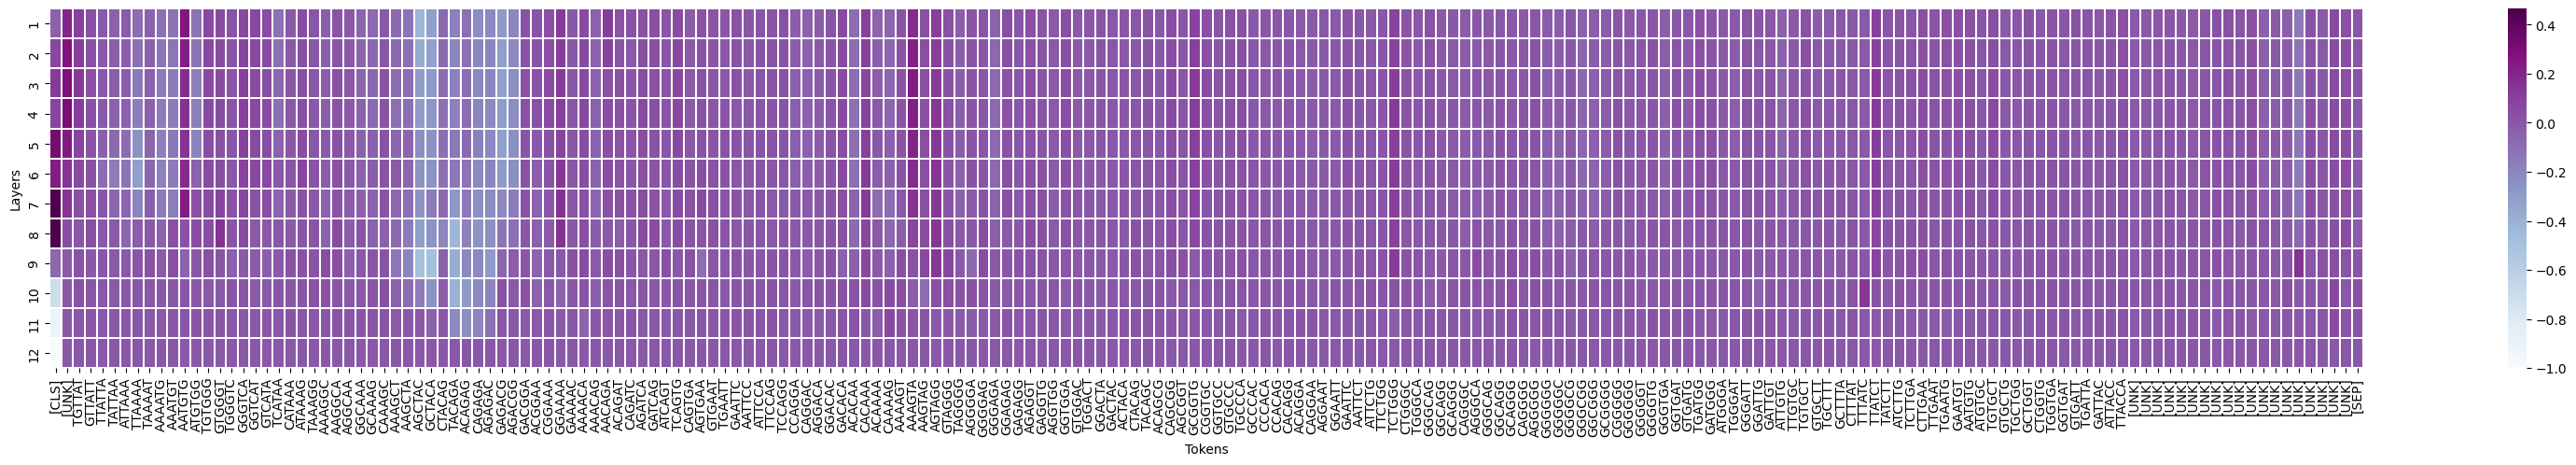

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(figsize=(40,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))  
ax = sns.heatmap(np.array(layer_attrs), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2, cmap='BuPu')  # cmap='viridis'
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

We can observe higher attribution score for few tokens throughout all layers.

Dig deeper into specific tokens and look into the distribution of attributions per layer for the chosen token. 

The box plot diagram below shows the presence of outliers especially in almost all layers.

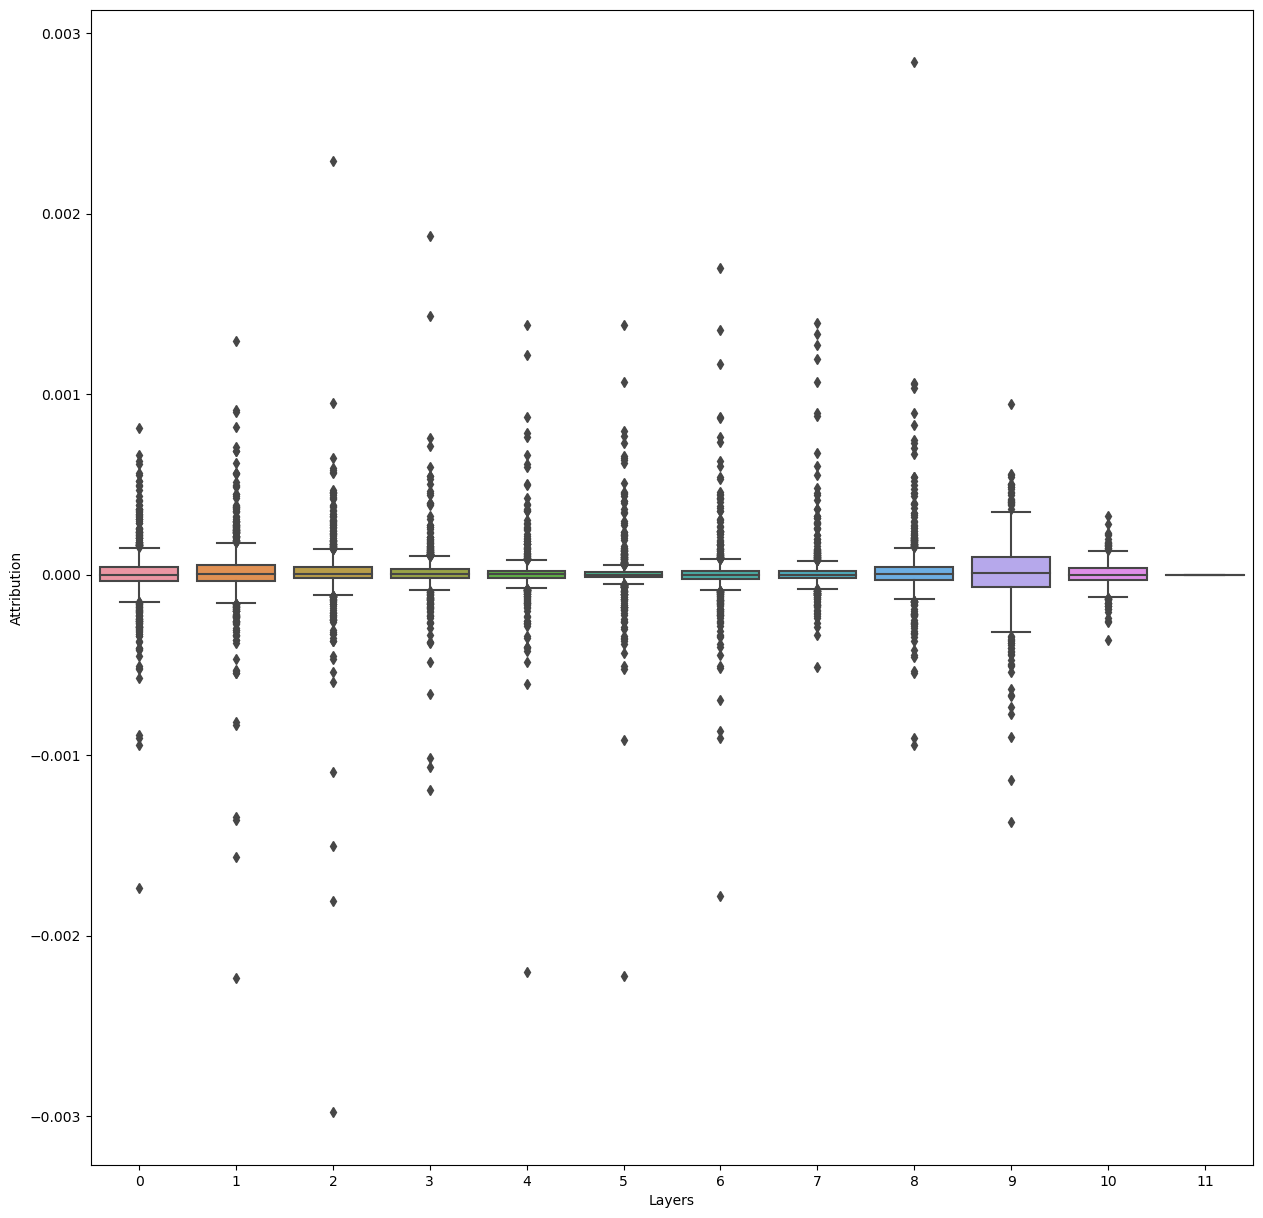

In [71]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.boxplot(data=layer_attrs_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In addition to that we can also look into the distribution of attributions in each layer for any input token. This will help us to better understand and compare the distributional patterns of attributions across multiple layers. We can for example represent attributions as a probability density function (`pdf`) and compute the entropy of it in order to estimate the entropy of attributions in each layer. This can be easily computed using a histogram.

In [72]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In this particular case let's compute the `pdf` for the attributions of the chosen token. We can however do it for all tokens.

Compute and visualize the `pdf`s and entropies using Shannon's Entropy measure for each layer for the chosen token:

In [73]:
layer_attrs_pdf = map(lambda layer_attrs_dist: pdf_attr(layer_attrs_dist), layer_attrs_dist)
layer_attrs_pdf = np.array(list(layer_attrs_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_dist).sum(-1)

# size: #layers
layer_attrs_pdf_norm = np.linalg.norm(layer_attrs_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_pdf = np.transpose(layer_attrs_pdf)

#size: #bins x #layers
layer_attrs_pdf = np.divide(layer_attrs_pdf, layer_attrs_pdf_norm, where=layer_attrs_pdf_norm!=0)

The plot below visualizes the probability mass function (`pmf`) of attributions for each layer for the position of the chosen token. From the plot we can observe that the distributions are taking bell-curved shapes with different means and variances. We can now use attribution `pdf`s to compute entropies in the next cell.

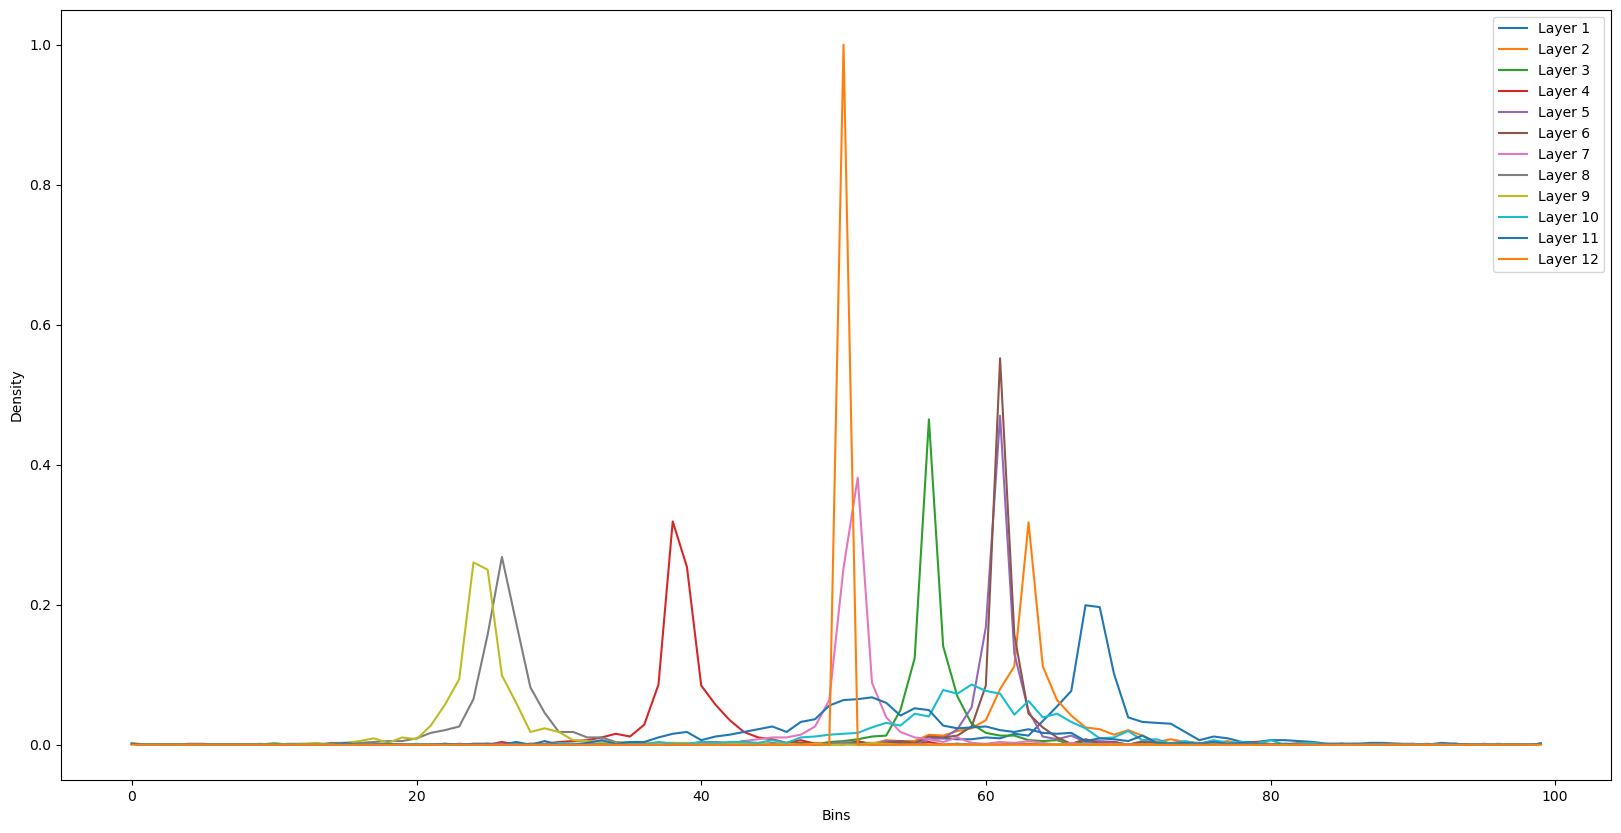

In [74]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

Calculate and visualize attribution entropies based on Shannon entropy measure where the X-axis corresponds to the number of layers and the Y-axis corresponds to the total attribution in that layer. The size of the circles for each (layer, total_attribution) pair correspond to the normalized entropy value at that point.

In this particular example, we observe that the entropy changes from layer to layer. 

**In a general case entropy can provide us an intuition about the distributional characteristics of attributions in each layer and can be useful especially when comparing it across multiple tokens.**


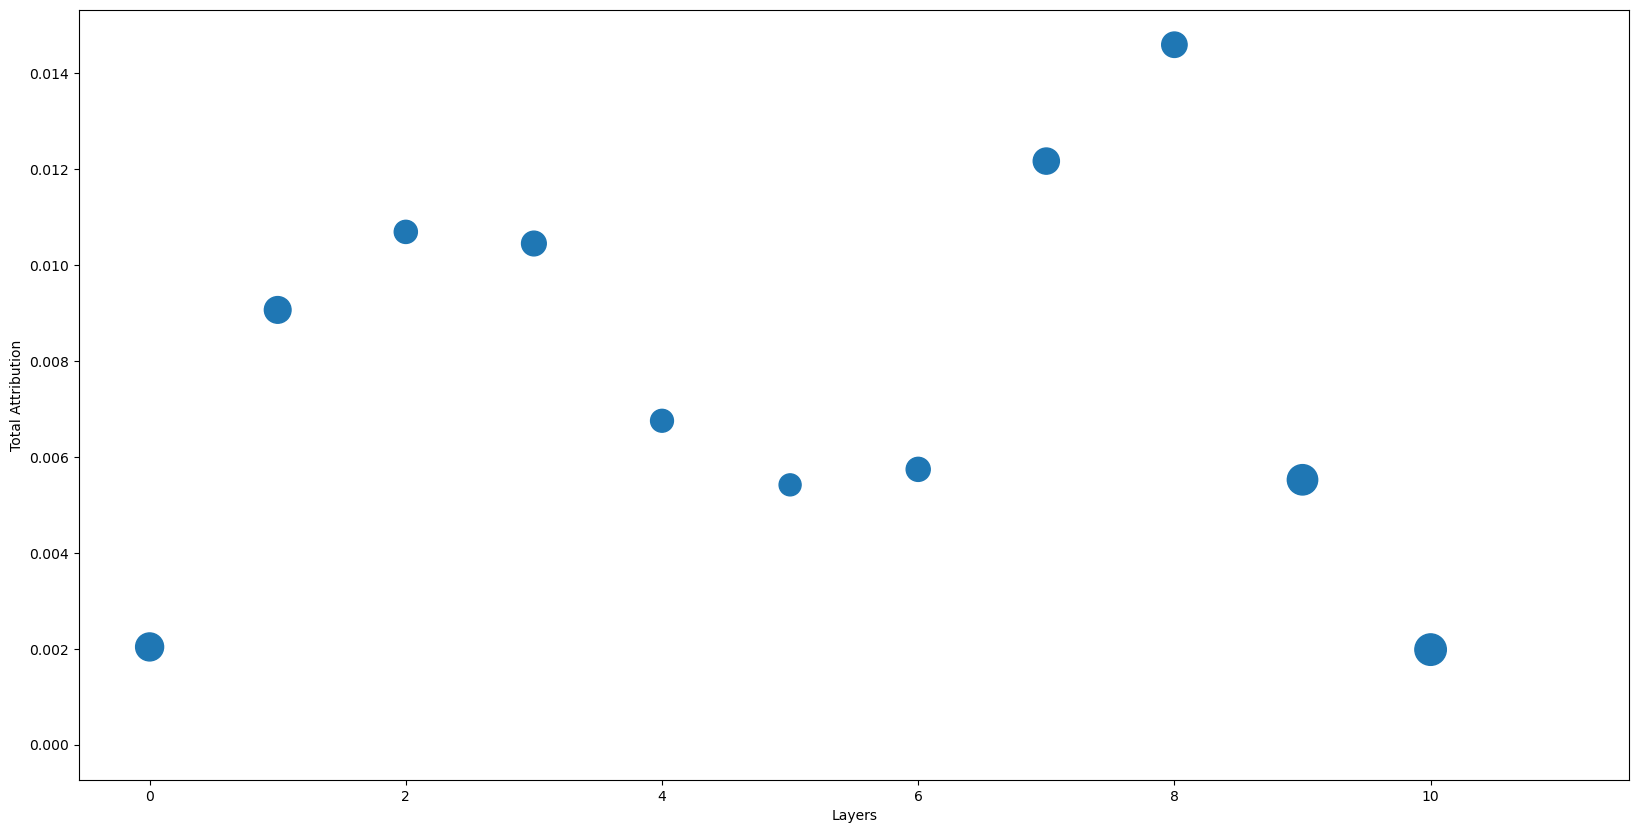

In [75]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_pdf[layer_attrs_pdf == 0] = 1
layer_attrs_pdf_log = np.log2(layer_attrs_pdf)

# size: #layers
entropies= -(layer_attrs_pdf * layer_attrs_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()

## Attention matrices, their importance scores, and vector norms

Continuing according to this tutorial: https://captum.ai/tutorials/Bert_SQUAD_Interpret2 

As proposed in paper [Attention is Not Only a Weight: Analyzing Transformers with Vector Norms](https://arxiv.org/abs/2004.10102) we will compare attention matrices with their importance scores when we attribute them to a particular class, and vector norms.

It will be shown that the importance scores computed for the attention matrices and specific class are more meaningful than the attention matrices alone or different norm vectors computed for different input activations.

## [Visualizing Attention Matrices](https://captum.ai/tutorials/Bert_SQUAD_Interpret2#Visualizing-Attention-Matrices)

If we want to get the `attentions` fro mmodel as well, we need to pass "output_attentions=True" when initializing the model as well! 

https://huggingface.co/docs/transformers/main_classes/output

In [76]:
def predict4(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    score = model(inputs, 
                  token_type_ids=token_type_ids,
                  position_ids=position_ids, 
                  attention_mask=attention_mask)
    return score[0], score.attentions

`output_attentions` 

- represent attention matrices (attention probabilities) for all 12 layers and all 12 heads
- represents softmax-normalized dot-product between the key and query vectors
- has been used as an importance indicator of how much a token attends/ relates to another token in the text (https://www.aclweb.org/anthology/W19-4828.pdf)

*Examples:*

- *in translation it is a good indicator of how much a token in one language attends to the corresponding translation in another language*
- *in Question Answering model it indicates which tokens attend/ relate to each other in question, text or answer segment*

Since `output_attentions` contains the layers in a list, we will stack them in order to move everything into a tensor:attention_mask

In [77]:
scores, output_attentions = predict4(input_ids,
                                     token_type_ids=token_type_ids,
                                     position_ids=position_ids, 
                                     attention_mask=attention_mask)

In [78]:
scores

tensor([[-0.0095,  0.0876]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [79]:
print(output_attentions is None)

False


In [80]:
# shape -> layer x batch x head x seq_len x seq_len
output_attentions_all = torch.stack(output_attentions)
# output_attentions_all

**Helper function for visualizing Token-To-Token matices:**

*(visualize token-to-token relation/ attention scores for all heads in a given layer or for all layers across all heads)*

In [81]:
# TODO: fix visual (too many tokens)

def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

**Helper function for visualizing Token-To-Head matrices:**

*(visualize the importance scores for tokens across all heads in all layers)*

In [82]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

Examine a specific layer: Define a fixed layer id that will be used for visualization purposes. 

In [83]:
layer = 11

Visualize attention matrices for the selected layer `layer`:

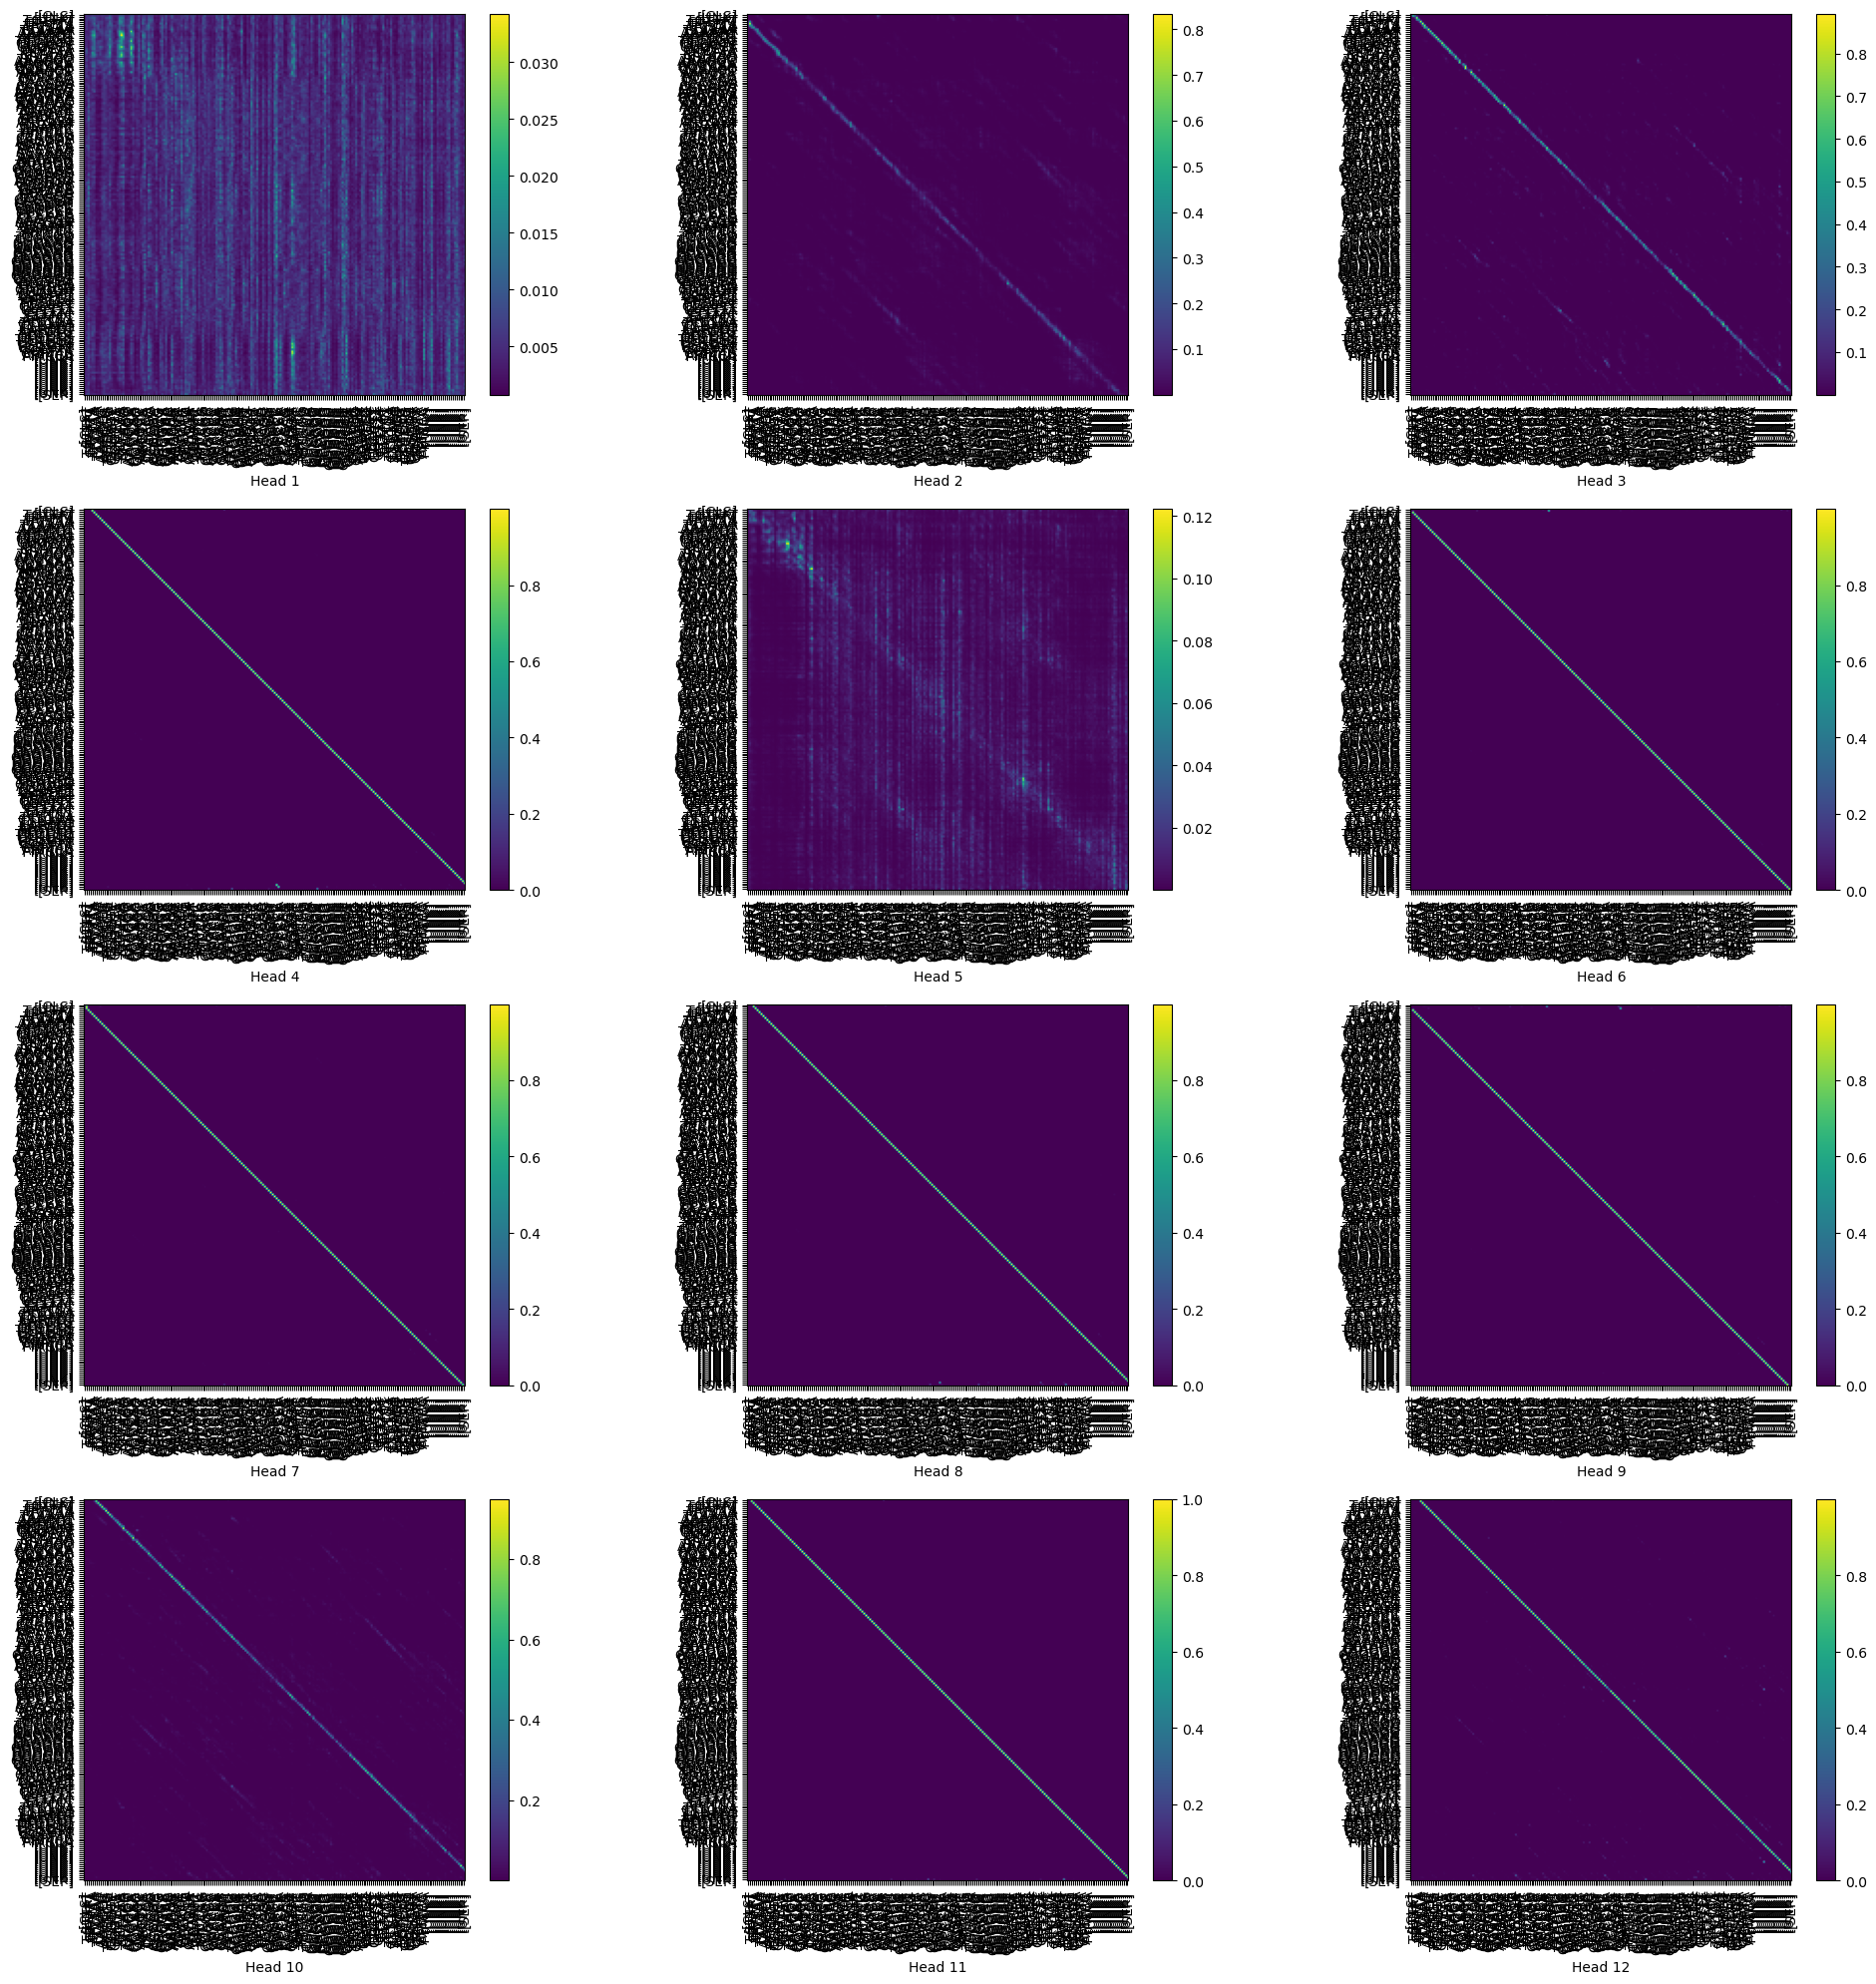

In [84]:
visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy())

Based on the visualizations above we observe that there is a high attention set along the diagonals and on an uninformative token such as `[SEP]`. This is something that was observed in previous papers which indicates that attention matrices aren't always a good indicator of finding which tokens are more important or which token is related to which. We observe similar pattern when we examine another layer.

In the cell below we compute and visualize L2 norm across head axis for all 12 layer. This provides a summary for each layer across all heads.

Defining normalization function depending on pytorch version.

In [85]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

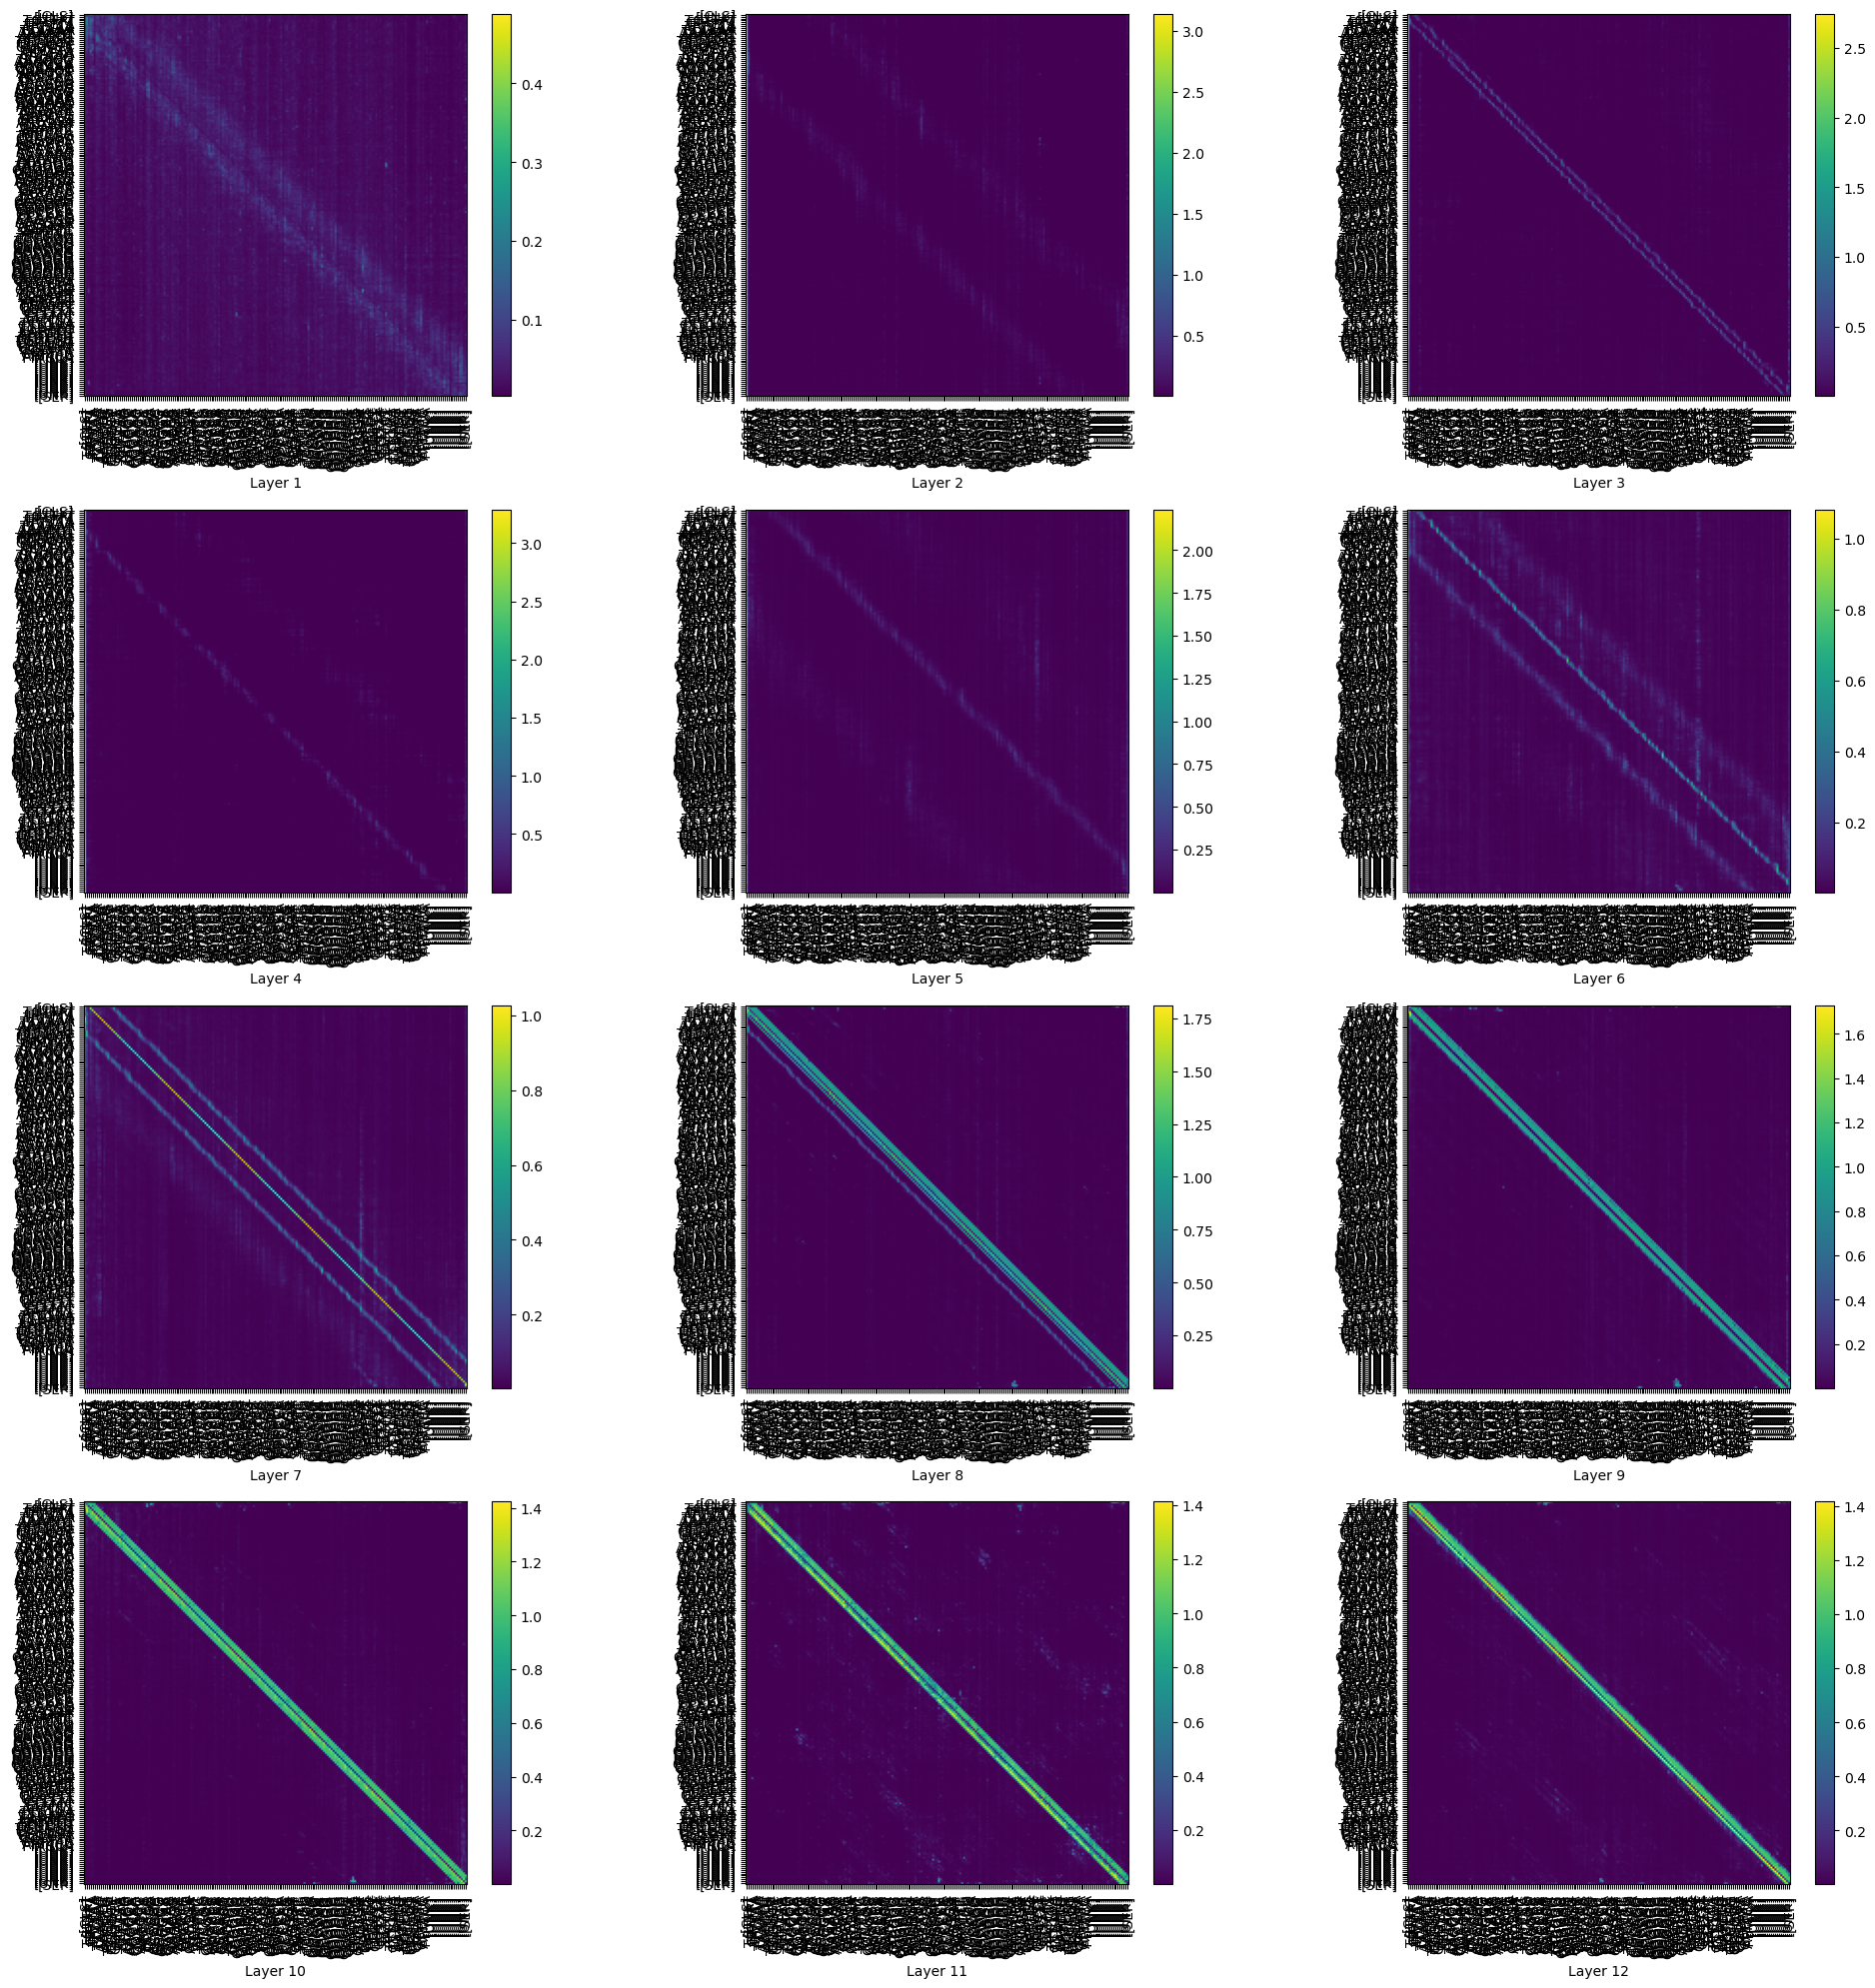

In [86]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

Based on the visualiziation above we can convince ourselves that attention scores aren't trustworthy measures of importances for token-to-token relations across all layers. We see strong signal along the diagonal. These signals, however, aren't true indicators of what semantic the model learns.

## [Visualizing attribution/ importance scores](https://captum.ai/tutorials/Bert_SQUAD_Interpret2#Visualizing-attribution-/-importance-scores)

In the cells below we visualize the attribution scores of attention matrices for the prediction and compare with the actual attention matrices. To do so, first of all, we compute the attribution scores using `LayerConductance` algorithm.

Helper function to summarize attributions for each word token in the sequence:

In [87]:
# difference from "summarize_attributions": torch.norm -> norm_fn

def summarize_attributions2(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions/ norm_fn(attributions)
    return attributions

## [Interpreting BertLayer Outputs and Self-Attention Matrices in each Layer](https://captum.ai/tutorials/Bert_SQUAD_Interpret2#Visualizing-Attention-Matrices)

Let's look into the layers of our network - into the distribution of attribution scores for each token across all layers and attribution matrices for each head in all layers in Bert model => Layer Conductance algorithm.

Sample:

In [88]:
tokenized_sample = dataset['test'][1]['input_ids']
tokenized_sample = tokenized_sample[1:len(tokenized_sample)-1]
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(tokenized_sample, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

Configure the `InterpretableEmbeddingsBase` again, in this case in order to interpret the layers of our model:

In [89]:
from captum.attr import configure_interpretable_embedding_layer

interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings.word_embeddings')

/home/jovyan/my-conda-envs/ml_env/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [90]:
def predict5(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    score = model(inputs_embeds=inputs, 
                  token_type_ids=token_type_ids,
                  position_ids=position_ids, 
                  attention_mask=attention_mask)
    return score[0].max(1).values

Iterate over all layers and compute the attributions w.r.t. all tokens in the input and attention matrices:

In [91]:
layer_attrs = []
layer_attn_mat = []

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(predict5, model.bert.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids, attention_mask))
    layer_attrs.append(summarize_attributions2(layer_attributions[0]))
    layer_attn_mat.append(layer_attributions[1])

In [92]:
# layer x seq_len
layer_attrs = torch.stack(layer_attrs)

# layer x batch x head x seq_len x seq_len
layer_attn_mat = torch.stack(layer_attn_mat)

## [Interpreting Attribution Scores for Attention Matrices](https://captum.ai/tutorials/Bert_SQUAD_Interpret2#Interpreting-Attribution-Scores-for-Attention-Matrices)

Visualize the attribution scores of position predictions w.r.t. attention matrices. Note that each layer has 12 heads, hence attention matrices. We will first visualize for a specific layer and head, later we will summarize across all heads in order to gain a bigger picture.

Below we visualize the attribution scores of 12 heads for selected layer layer for position prediction:

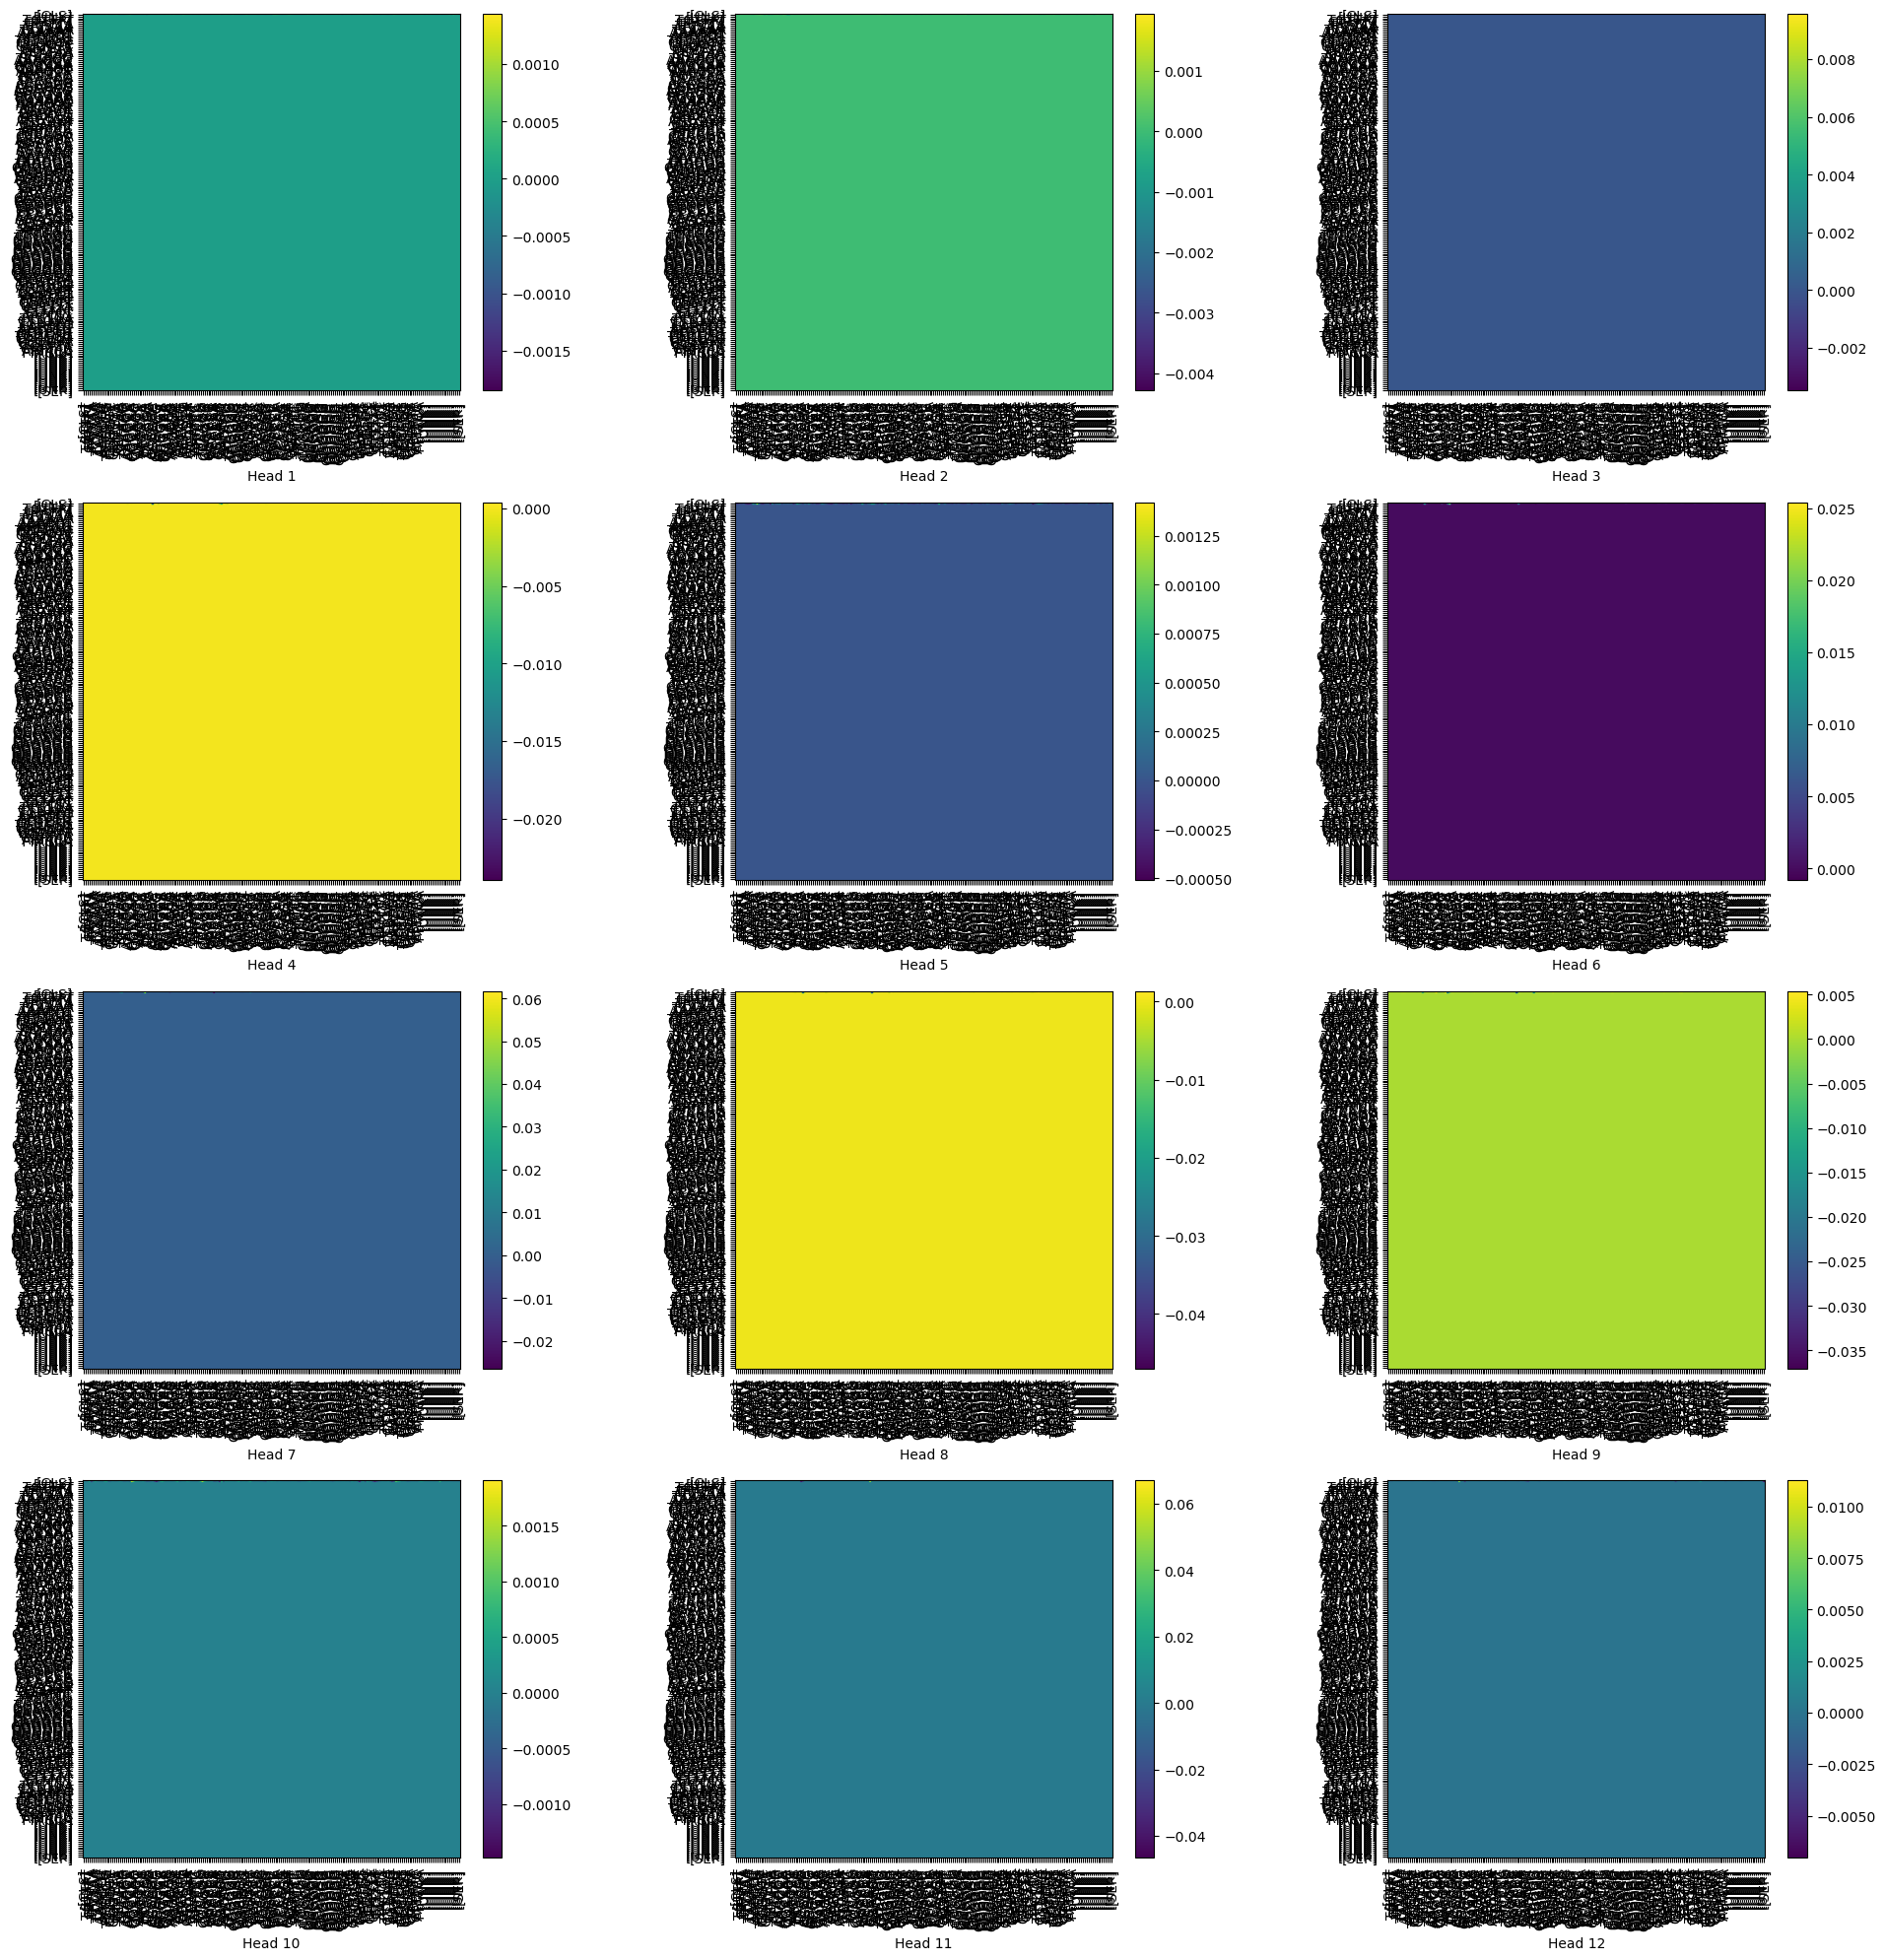

In [93]:
visualize_token2token_scores(layer_attn_mat[layer].squeeze().cpu().detach().numpy())

As we can see from the visualizations above, in contrary to attention scores the attributions of specific target w.r.t. to those scores are more meaningful and most importantly -> they do not show diagonal patterns. 

These observations are for a selected layer. We can change the index of selected layer and examine interesting relationships in other layers.

In the cell below we visualize the attention attribution scores normalized across the head axis.

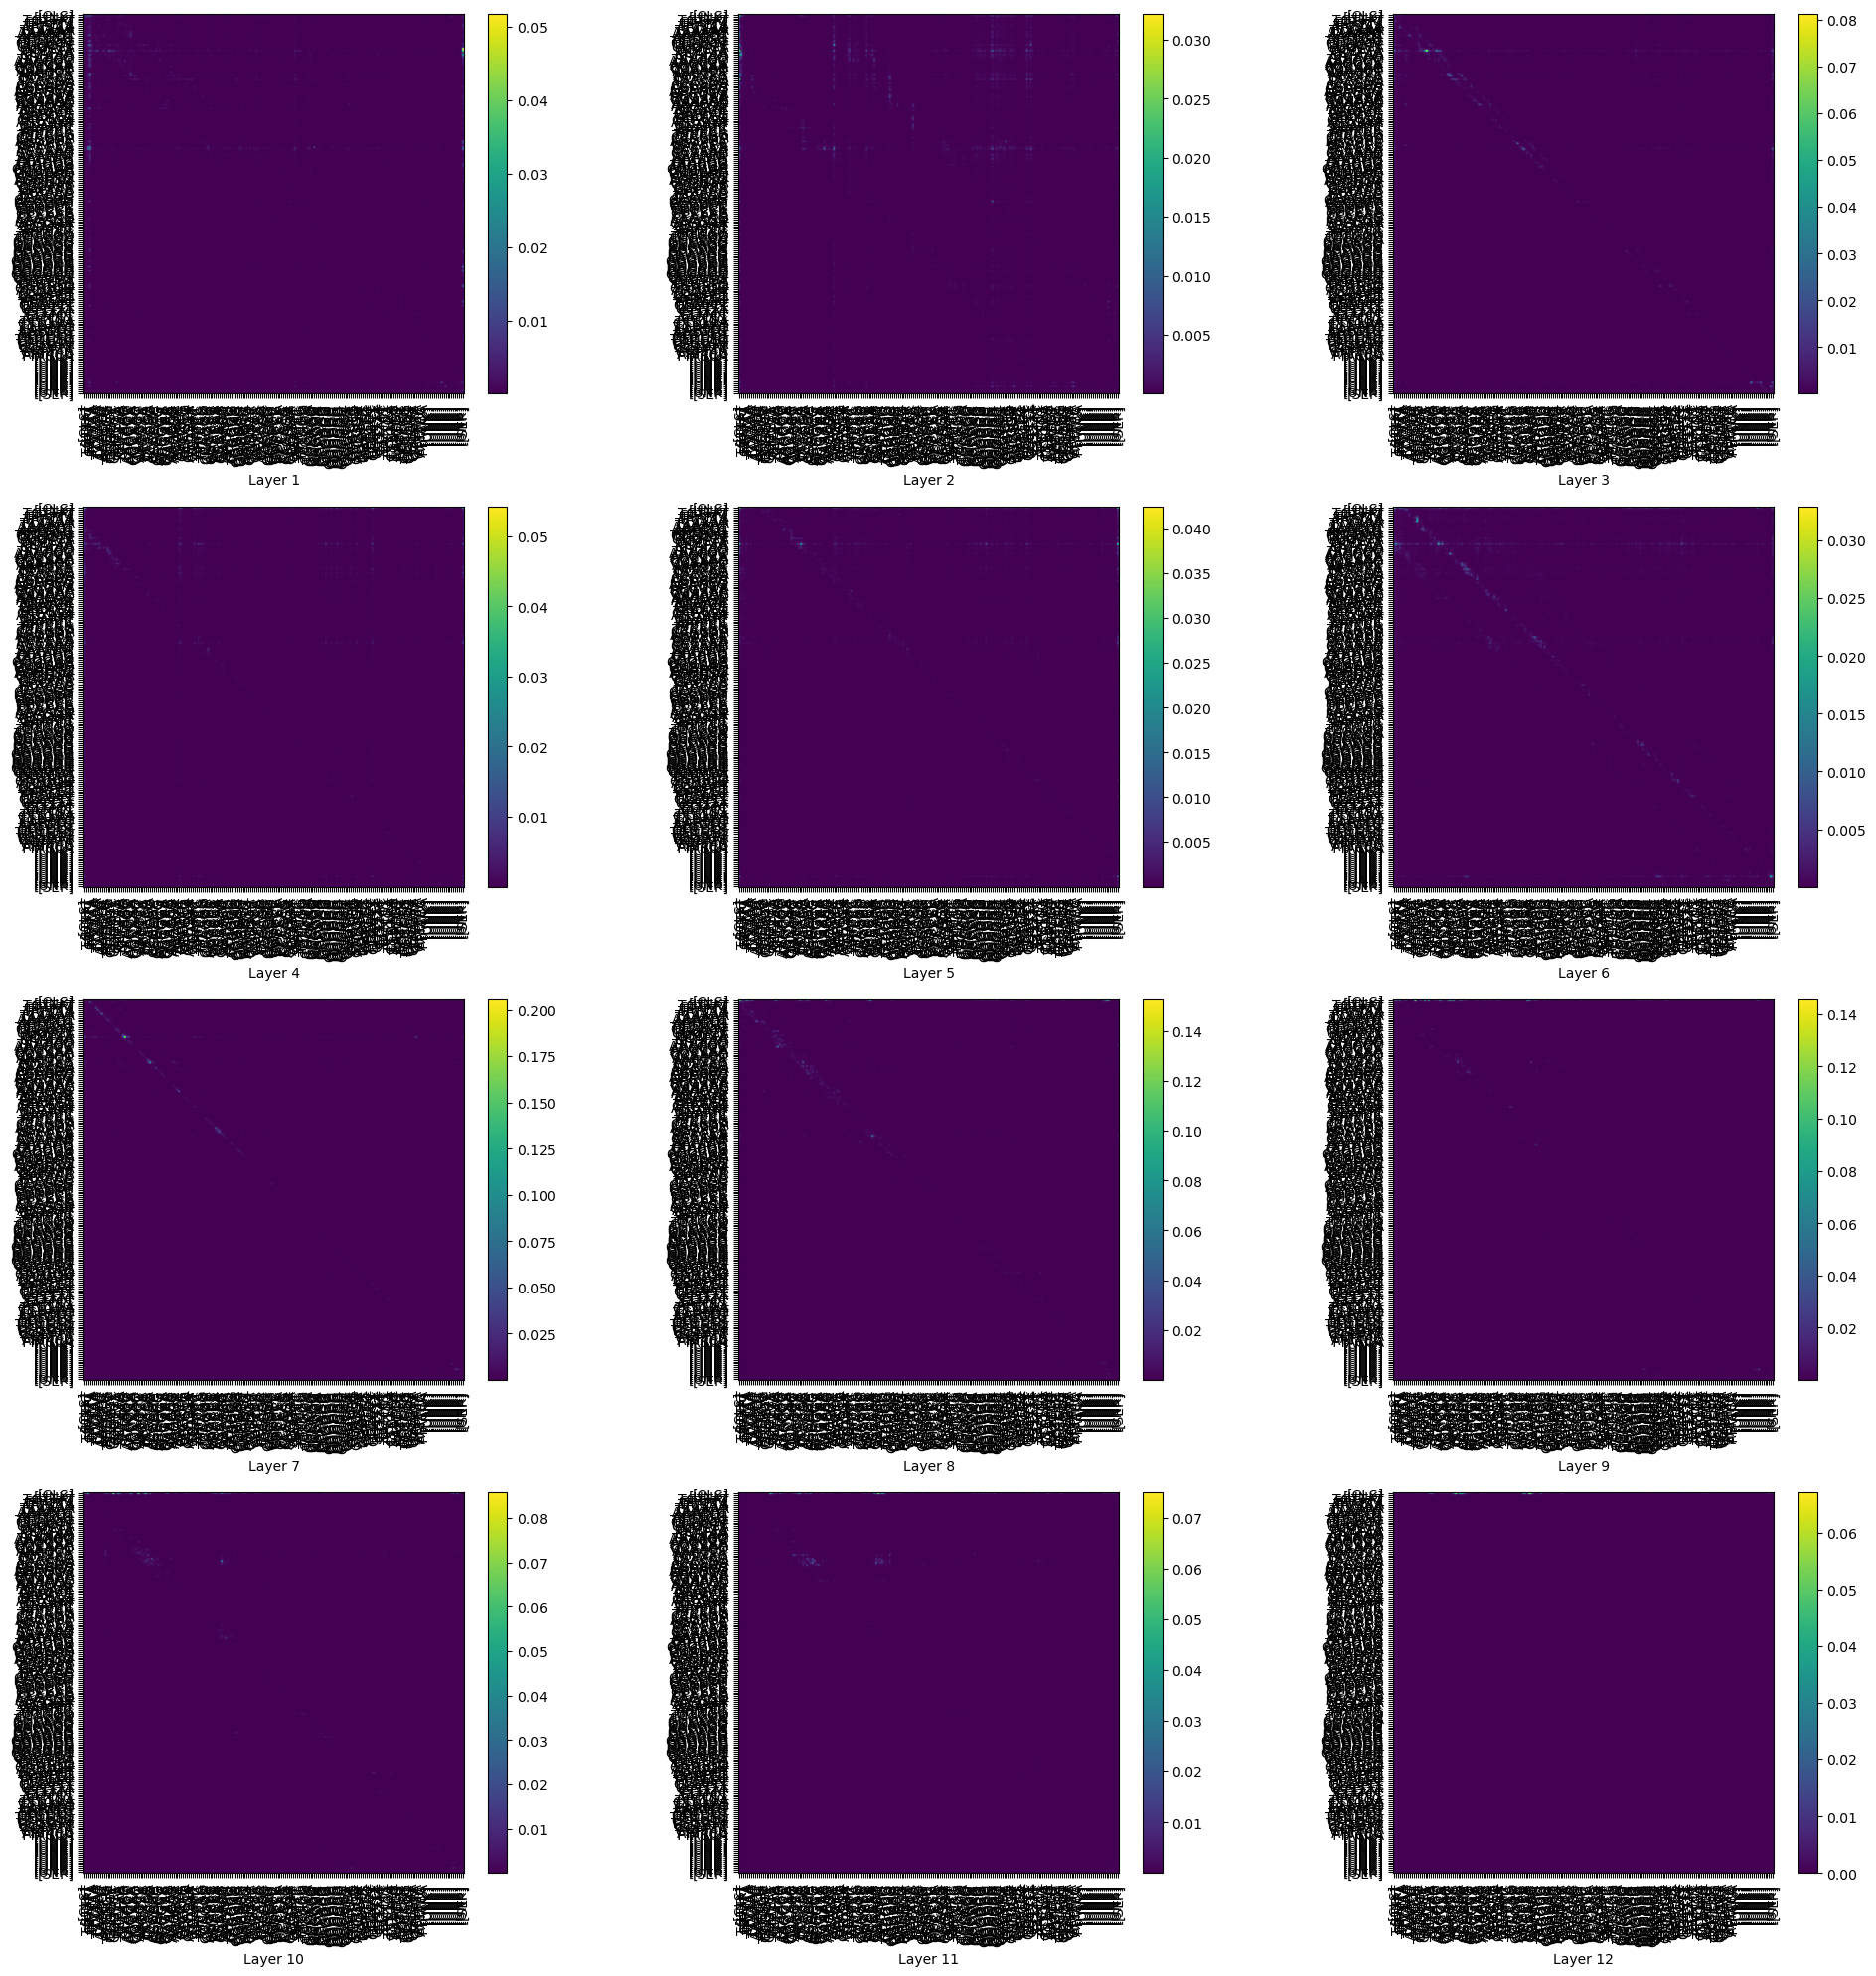

In [94]:
visualize_token2token_scores(norm_fn(layer_attn_mat, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

By looking at the visualizations above we can see that the model pays attention to very specific handpicked relationships when making a sprediction for the position.

## [Computing and Visualizing Vector Norms](https://captum.ai/tutorials/Bert_SQUAD_Interpret2#Computing-and-Visualizing-Vector-Norms)

In this section of the tutorial we will compute Vector norms for activation layers such as `||f(x)||`, `||α * f(x)||` and `||Σαf(x)||` as also described in https://arxiv.org/pdf/2004.10102.pdf

As also shown in the paper mentioned above, normalized activations are better indicators of importance scores than the attention scores however they aren't as indicative as the attribution scores. This is because normalized activations `||f(x)||` and `||α * f(x)||` aren't attributed to a specific output prediction. 

Below we define/ extract all parameters that we need to computation vector norms:

In [95]:
output_attentions_all_shape = output_attentions_all.shape

batch = output_attentions_all_shape[1]
num_heads = output_attentions_all_shape[2]
head_size = 64
all_head_size = 768

In order to compute above mentioned norms we need to get access to dense layer's weights and value vector of the self attention layer.

Getting Access to Value Activations: define the list of all layers for which we would like to access Value Activations

In [96]:
layers = [model.bert.encoder.layer[layer].attention.self.value for layer in range(len(model.bert.encoder.layer))]

Use Captum's `LayerActivation` algorithm to access the outputs of all layers:

*(Perform several transformations with the value layer activations and bring it to the shape so that we can compute different norms. The transformations are done the same way as it is described in the original paper and corresponding github implementation.)*

In [97]:
from captum.attr import LayerActivation

la = LayerActivation(predict5, layers)

value_layer_acts = la.attribute(input_embeddings, additional_forward_args=(token_type_ids, position_ids, attention_mask))
# shape -> layer x batch x seq_len x all_head_size
value_layer_acts = torch.stack(value_layer_acts)

In [98]:
new_x_shape = value_layer_acts.size()[:-1] + (num_heads, head_size)
value_layer_acts = value_layer_acts.view(*new_x_shape)

# layer x batch x neum_heads x 1 x head_size
value_layer_acts = value_layer_acts.permute(0, 1, 3, 2, 4)

value_layer_acts = value_layer_acts.permute(0, 1, 3, 2, 4).contiguous()
value_layer_acts_shape = value_layer_acts.size()

# layer x batch x seq_length x num_heads x 1 x head_size
value_layer_acts = value_layer_acts.view(value_layer_acts_shape[:-1] + (1, value_layer_acts_shape[-1],))

print('value_layer_acts: ', value_layer_acts.shape)

value_layer_acts:  torch.Size([12, 1, 197, 12, 1, 64])


Getting Access to Dense Features: transform dense features so that we can use them to compute `||f(x)||` and `||α * f(x)||`

In [99]:
dense_acts = torch.stack([dlayer.attention.output.dense.weight for dlayer in model.bert.encoder.layer])

dense_acts = dense_acts.view(len(layers), all_head_size, num_heads, head_size)

# layer x num_heads x head_size x all_head_size
dense_acts = dense_acts.permute(0, 2, 3, 1).contiguous()

Compute `f(x)` score by multiplying the value vector with the weights of the dense vector for all layers:

In [100]:
# layers, batch, seq_length, num_heads, 1, all_head_size
f_x = torch.stack([value_layer_acts_i.matmul(dense_acts_i) for value_layer_acts_i, dense_acts_i in zip(value_layer_acts, dense_acts)])
f_x.shape

torch.Size([12, 1, 197, 12, 1, 768])

In [101]:
# layer x batch x seq_length x num_heads x 1 x all_head_size)
f_x_shape = f_x.size() 
f_x = f_x.view(f_x_shape[:-2] + (f_x_shape[-1],))
f_x = f_x.permute(0, 1, 3, 2, 4).contiguous() 

#(layers x batch, num_heads, seq_length, all_head_size)
f_x_shape = f_x.size() 

#(layers x batch, num_heads, seq_length)
f_x_norm = norm_fn(f_x, dim=-1)

Visualize `||f(x)||` scores for all layers and examine the distribution of those scores:

In [102]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (197).

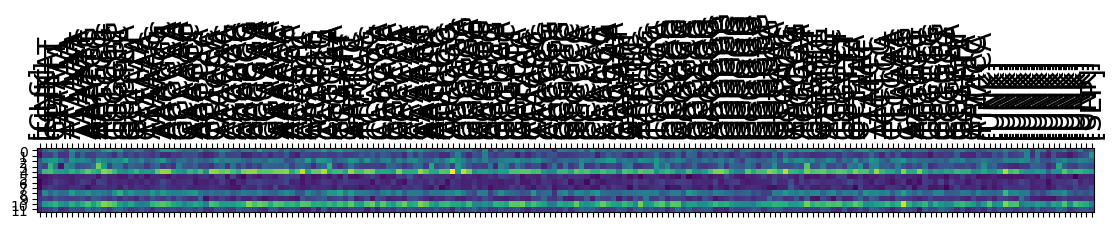

In [103]:
visualize_token2head_scores(f_x_norm.squeeze().detach().cpu().numpy())